мастерская-m-1-44-ds-Евгений-С.ipynb

2025-02-25

# Описание задачи

Требуется проанализировать псевдо-реальные (реальные данные в которые добавлена синтетическая составляющая) данные о стартапах, функционировавших в период с 1970 по 2018 годы, и **предсказать, какие из них закроются**.

Метрикой в этом соревновании является **F1-Score**.

## Цель проекта: 
1. Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
1. Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).


## Описание данных

Датасет состоит из двух файлов (+пример с выгрузкой): тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

- kaggle_startups_train.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Задача в том, чтобы **предсказать значение 'status'** для каждого стартапа из этого датасета.
- kaggle_startups_sample_submit.csv - файл с примером предсказаний в правильном формате.

https://www.kaggle.com/competitions/startups-operations-close-predictions-m-1-44-ds/data

- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий) - **целевой признак**
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

# Выполнение проекта

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.combine import SMOTETomek

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, 
                                   MinMaxScaler, StandardScaler)
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from sklearn import metrics

In [3]:
!pip install imblearn -q
!pip install phik -q

In [4]:
!pip install shap -q

import shap
from shap.plots import beeswarm

In [5]:
import phik
from imblearn.under_sampling import RandomUnderSampler

In [6]:
RANDOM_STATE = 42
#pd.set_option('display.max_columns', None)

In [7]:
def correct_path (csv_name):
    if not os.path.exists(csv_name):
        return '/kaggle/input/startups-operations-close-predictions-m-1-44-ds/' + csv_name
    return csv_name

# визуализирует все категориальные фичи датафрейма в виде пирогов
# визуализирует все категориальные фичи датафрейма в виде ящиков с усами и гистограмм с распределением, выводит descirbe
# поддерживает любое количество фильтров, фильтры поочерёдно применяются к датафрейму как запрос в query(),
#   графики выводятся для каждого фильтра
#   чтобы вывести графики без фильтра нужно передать пустой запрос, или же не передавать фильтры вовсе

def do_eda(df, filters=[]):
    bins=25
    n_filters = len(filters)
    PIE_WIDTH = 5

    # вывод графиков по категориальным фичам 
    for column in df:
        if df[column].dtype == 'O':
            title0 = f"столбец {column}"
            df_show = df[column]
            if n_filters > 0 and filters[0] != '':
                title = title0 + f"\nфильтр: {filters[0]}"
                df_show = df.query(filters[0])[column]
            if n_filters <= 1:
                ax = df_show.value_counts().plot(title=title0, kind='pie', 
                                                 figsize=(PIE_WIDTH, PIE_WIDTH), 
                                                 autopct=lambda x: f"{x:.0f}%");
                ax.set_ylabel('')
            else:
                fig, axes = plt.subplots(1, n_filters, 
                                         figsize=(PIE_WIDTH*n_filters, PIE_WIDTH))
                for i in range (n_filters):
                    if filters[i] != '':
                        title = title0 + f"\nфильтр: {filters[i]}"
                        df_show = df.query(filters[i])[column]
                    else:
                        title = title0
                    ax = df_show.value_counts().plot(ax=axes[i], 
                                                     title=title, kind='pie', 
                                                     autopct=lambda x: f"{x:.0f}%");
                    ax.set_ylabel('')
        plt.show();

    # вывод графиков по числовым фичам 
    if n_filters == 0:
        filters = ['']
        n_filters = 1
    for column in df:
        if df[column].dtype in ['int64', 'float64'] and column != "id":
            display (f"********** Следующий признак: {column}")
            fig, axs = plt.subplots(nrows=2*max(1, n_filters), ncols=1, 
                                    figsize=(6, 7*n_filters))
            for i in range (n_filters):
                title = f"столбец {column}"
                df_show = df[column]
                if filters[i] != '':
                    title = title + f", фильтр: {filters[i]}"
                    df_show = df.query(filters[i])[column]
                axs[i*2].boxplot(df_show, vert=False);
                ##v1 sns.boxplot(data=df_show, ax=axs[i*2], palette=['lightsteelblue'], orient='h')
                axs[i*2].set_title(title, fontsize=9)
                sns.histplot(df_show, bins=bins, kde=True, ax=axs[i*2+1], alpha=0.8)
                axs[i*2+1].set_xlabel('')
                display(f"фильтр = '{filters[i]}'")
                display(df_show.describe())
            plt.show();

def def_load_csv(csv, no_print=False):
    df = pd.read_csv(correct_path(csv))
    if not no_print:
        display(df.info())
        display(df.head())
    return df

## загрузка и ознакомление с данными

In [8]:
train_df = def_load_csv ('kaggle_startups_train_28062024.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [9]:
test_X_df = def_load_csv ('kaggle_startups_test_28062024.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


Выводы по загруженным данным:
- поле `category_list` содержит список категорий, разделённых символом '|'
    - 👷✅: будет лучше применить заменить их на отдельные столбцы после укрупнения категорий (как порекомендовал наставник)
- `status` - является target-признаком - его будет также лучше заэнкодить 
    - 👷✅: проще это будет сделать явно задав нужному классу нужное значение
- `founded_at`, `first_funding_at`, `last_funding_at` (и, предположительно, `closed_at`) - даты, но имеют тип поля object
    - 👷✅: стОит перевести в поле типа даты
- поле `closed_at` - есть только в train датасете, но его нет в test-датасете. К тому же closed_at - сможет подсказать модели статус (то есть, таргет-признак) - тогда будет иметь место утечка целевого признака.
    - 👷✅: во избежание утечки данных и утечки целевого признака - данный столбец из тренировочного набора будет нужно удалить.  
- в тестовой выборке нет поля founded_at, но есть дата lifetime и при этом известна дата формирования выгрузки - '2018-01-01'
    - 👷✅: нужно в тествой выборке создать вычисленный столбец founded_at и удалить lifetime

🏭 [data transformation] this change should be done before training/testing/inference

### укрупнение категорий

In [10]:
# поищем уникальные значения категорий
cat_set = set()
for cat in train_df['category_list']:
    if cat==cat: # skip NaN
        for c in cat.split('|'):
            cat_set.add(c)
display (cat_set, len (cat_set))

{'3D',
 '3D Printing',
 '3D Technology',
 'Accounting',
 'Active Lifestyle',
 'Ad Targeting',
 'Adaptive Equipment',
 'Advanced Materials',
 'Adventure Travel',
 'Advertising',
 'Advertising Exchanges',
 'Advertising Networks',
 'Advertising Platforms',
 'Advice',
 'Aerospace',
 'Agriculture',
 'Air Pollution Control',
 'Algorithms',
 'All Markets',
 'All Students',
 'Alternative Medicine',
 'Alumni',
 'Analytics',
 'Android',
 'Angels',
 'Animal Feed',
 'Anything Capital Intensive',
 'App Discovery',
 'App Marketing',
 'App Stores',
 'Application Performance Monitoring',
 'Application Platforms',
 'Apps',
 'Aquaculture',
 'Architecture',
 'Archiving',
 'Art',
 'Artificial Intelligence',
 'Artists Globally',
 'Assisitive Technology',
 'Assisted Living',
 'Auctions',
 'Audio',
 'Audiobooks',
 'Augmented Reality',
 'Auto',
 'Automated Kiosk',
 'Automotive',
 'B2B',
 'B2B Express Delivery',
 'BPO Services',
 'Babies',
 'Baby Accessories',
 'Baby Boomers',
 'Baby Safety',
 'Banking',
 'Bat

854

+853 столбца (onehotencoder) - слишком много

много ли строк с объединёнными через через '|' категориями? если их мало - можно пренебречь

In [11]:
train_df [train_df['category_list'].str.find('|') != -1]['category_list'].value_counts()

Biotechnology|Health Diagnostics                                                               186
EdTech|Education                                                                               129
Finance|FinTech                                                                                123
Entertainment|Games                                                                            114
Biotechnology|Health Care                                                                       93
                                                                                              ... 
Application Platforms|Health Care Information Technology|Internet Marketing|Web Development      1
Employment|Finance|Social Media|Startups                                                         1
Collaborative Consumption|Marketplaces|Travel|Vacation Rentals                                   1
Apps|Contact Management|Internet|Social Media|Software                                           1
E-Commerce

21 тыс уникальных комбинаций - много.

А какого размер словарь только для них? Если небольшой - возможно, сможем себе позволить доп-столбцы для этих нескольких категорий?

In [12]:
cat_set = set()
for cat in train_df [train_df['category_list'].str.find('|') != -1]['category_list']:
    if cat==cat: # skip NaN
        for c in cat.split('|'):
            cat_set.add(c)
display (cat_set, len (cat_set))

{'3D',
 '3D Printing',
 '3D Technology',
 'Accounting',
 'Active Lifestyle',
 'Ad Targeting',
 'Adaptive Equipment',
 'Advanced Materials',
 'Adventure Travel',
 'Advertising',
 'Advertising Exchanges',
 'Advertising Networks',
 'Advertising Platforms',
 'Advice',
 'Aerospace',
 'Agriculture',
 'Air Pollution Control',
 'Algorithms',
 'All Markets',
 'All Students',
 'Alternative Medicine',
 'Alumni',
 'Analytics',
 'Android',
 'Angels',
 'Animal Feed',
 'Anything Capital Intensive',
 'App Discovery',
 'App Marketing',
 'App Stores',
 'Application Performance Monitoring',
 'Application Platforms',
 'Apps',
 'Aquaculture',
 'Architecture',
 'Archiving',
 'Art',
 'Artificial Intelligence',
 'Artists Globally',
 'Assisitive Technology',
 'Assisted Living',
 'Auctions',
 'Audio',
 'Audiobooks',
 'Augmented Reality',
 'Auto',
 'Automated Kiosk',
 'Automotive',
 'B2B',
 'B2B Express Delivery',
 'BPO Services',
 'Babies',
 'Baby Accessories',
 'Baby Boomers',
 'Baby Safety',
 'Banking',
 'Bat

852

Словарь всё равно большой. Ну, что поделать. Подготовим заготовку (обсуждали на QnA word2vec, но мы его ещё не проходили, поэтому пока без него):

In [13]:
cat_set = set()
for cat in train_df['category_list']:
    if cat==cat: # skip NaN
        for c in cat.split('|'):
            cat_set.add(f"\'{c}\': ''")
display (cat_set)

{"'3D Printing': ''",
 "'3D Technology': ''",
 "'3D': ''",
 "'Accounting': ''",
 "'Active Lifestyle': ''",
 "'Ad Targeting': ''",
 "'Adaptive Equipment': ''",
 "'Advanced Materials': ''",
 "'Adventure Travel': ''",
 "'Advertising Exchanges': ''",
 "'Advertising Networks': ''",
 "'Advertising Platforms': ''",
 "'Advertising': ''",
 "'Advice': ''",
 "'Aerospace': ''",
 "'Agriculture': ''",
 "'Air Pollution Control': ''",
 "'Algorithms': ''",
 "'All Markets': ''",
 "'All Students': ''",
 "'Alternative Medicine': ''",
 "'Alumni': ''",
 "'Analytics': ''",
 "'Android': ''",
 "'Angels': ''",
 "'Animal Feed': ''",
 "'Anything Capital Intensive': ''",
 "'App Discovery': ''",
 "'App Marketing': ''",
 "'App Stores': ''",
 "'Application Performance Monitoring': ''",
 "'Application Platforms': ''",
 "'Apps': ''",
 "'Aquaculture': ''",
 "'Architecture': ''",
 "'Archiving': ''",
 "'Art': ''",
 "'Artificial Intelligence': ''",
 "'Artists Globally': ''",
 "'Assisitive Technology': ''",
 "'Assisted Livi

Удалим из неё заготовки кавычки, поэтапно будем пополнять список крупных категорий и размечать все неразмеченные исходные категории.

UPD: получился такой список крупных категорий. 24 фичи - уже не 800+, так что для них OHE уже подойдёт в свете того, что один объект/строка может подержать несколько признаков одновременно.

1. IT
1. Manufacturing
1. Materials
1. Technics
1. Finance
1. Media
1. Marketing
1. Consulting
1. Education
1. Social
1. Entertainments
1. Goods
1. Food
1. Health
1. Ecology
1. Sport
1. IT
1. Transport
1. Real Estate
1. Service
1. Kids
1. Animals
1. Geography
1. Other

In [14]:
CAT_DICT = \
{'3D Printing'	:	 'cat_manufacturing',
 '3D Technology'	:	 'cat_manufacturing',
 '3D'	:	 'cat_manufacturing',
 'Accounting'	:	 'cat_finance',
 'Active Lifestyle'	:	 'cat_entertainments',
 'Ad Targeting'	:	 'cat_it',
 'Adaptive Equipment'	:	 'cat_technics',
 'Advanced Materials'	:	 'cat_materials',
 'Adventure Travel'	:	 'cat_entertainments',
 'Advertising Exchanges'	:	 'cat_marketing',
 'Advertising Networks'	:	 'cat_marketing',
 'Advertising Platforms'	:	 'cat_marketing',
 'Advertising'	:	 'cat_marketing',
 'Advice'	:	 'cat_consulting',
 'Aerospace'	:	 'cat_transport',
 'Agriculture'	:	 'cat_manufacturing',
 'Air Pollution Control'	:	 'cat_ecology',
 'Algorithms'	:	 'cat_it',
 'All Markets'	:	 'cat_marketing',
 'All Students'	:	 'cat_education',
 'Alternative Medicine'	:	 'cat_health',
 'Alumni'	:	 'cat_social',
 'Analytics'	:	 'cat_it',
 'Android'	:	 'cat_it',
 'Angels'	:	 'cat_finance',
 'Animal Feed'	:	 'cat_animals',
 'Anything Capital Intensive'	:	 'cat_finance',
 'App Discovery'	:	 'cat_it',
 'App Marketing'	:	 'cat_it',
 'App Stores'	:	 'cat_it',
 'Application Performance Monitoring'	:	 'cat_it',
 'Application Platforms'	:	 'cat_it',
 'Apps'	:	 'cat_it',
 'Aquaculture'	:	 'cat_ecology',
 'Architecture'	:	 'cat_manufacturing',
 'Archiving'	:	 'cat_it',
 'Art'	:	 'cat_entertainments',
 'Artificial Intelligence'	:	 'cat_it',
 'Artists Globally'	:	 'cat_entertainments',
 'Assisitive Technology'	:	 'cat_entertainments',
 'Assisted Living'	:	 'cat_service',
 'Auctions'	:	 'cat_finance',
 'Audio'	:	 'cat_technics',
 'Audiobooks'	:	 'cat_technics',
 'Augmented Reality'	:	 'cat_it',
 'Auto'	:	 'cat_technics',
 'Automated Kiosk'	:	 'cat_technics',
 'Automotive'	:	 'cat_transport',
 'B2B Express Delivery'	:	 'cat_service',
 'B2B'	:	 'cat_service',
 'BPO Services'	:	 'cat_service',
 'Babies'	:	 'cat_kids',
 'Baby Accessories'	:	 'cat_kids',
 'Baby Boomers'	:	 'cat_kids',
 'Baby Safety'	:	 'cat_kids',
 'Banking'	:	 'cat_finance',
 'Batteries'	:	 'cat_technics',
 'Beauty'	:	 'cat_health',
 'Bicycles'	:	 'cat_sport',
 'Big Data Analytics'	:	 'cat_it',
 'Big Data'	:	 'cat_it',
 'Billing'	:	 'cat_it',
 'Bio-Pharm'	:	 'cat_ecology',
 'Biofuels'	:	 'cat_health',
 'Bioinformatics'	:	 'cat_health',
 'Biomass Power Generation'	:	 'cat_manufacturing',
 'Biometrics'	:	 'cat_it',
 'Biotechnology and Semiconductor'	:	 'cat_health',
 'Biotechnology'	:	 'cat_health',
 'Bitcoin'	:	 'cat_it',
 'Blogging Platforms'	:	 'cat_it',
 'Boating Industry'	:	 'cat_transport',
 'Brand Marketing'	:	 'cat_marketing',
 'Brewing'	:	 'cat_manufacturing',
 'Bridging Online and Offline'	:	 'cat_social',
 'Broadcasting'	:	 'cat_social',
 'Brokers'	:	 'cat_finance',
 'Browser Extensions'	:	 'cat_it',
 'Building Owners'	:	 'cat_manufacturing',
 'Building Products'	:	 'cat_manufacturing',
 'Business Analytics'	:	 'cat_consulting',
 'Business Development'	:	 'cat_consulting',
 'Business Information Systems'	:	 'cat_it',
 'Business Intelligence'	:	 'cat_consulting',
 'Business Productivity'	:	 'cat_consulting',
 'Business Services'	:	 'cat_service',
 'Business Travelers'	:	 'cat_service',
 'CAD'	:	 'cat_it',
 'CRM'	:	 'cat_it',
 'Cable'	:	 'cat_materials',
 'Call Center Automation'	:	 'cat_it',
 'Cannabis'	:	 'cat_health',
 'Carbon'	:	 'cat_materials',
 'Career Management'	:	 'cat_consulting',
 'Career Planning'	:	 'cat_consulting',
 'Cars'	:	 'cat_transport',
 'Casual Games'	:	 'cat_entertainments',
 'Cause Marketing'	:	 'cat_marketing',
 'Celebrity'	:	 'cat_social',
 'Certification Test'	:	 'cat_education',
 'Charities'	:	 'cat_social',
 'Charity'	:	 'cat_social',
 'Charter Schools'	:	 'cat_education',
 'Chat'	:	 'cat_it',
 'Chemicals'	:	 'cat_manufacturing',
 'Child Care'	:	 'cat_kids',
 'China Internet'	:	 'cat_it',
 'Civil Engineers'	:	 'cat_manufacturing',
 'Classifieds'	:	 'cat_social',
 'Clean Energy'	:	 'cat_ecology',
 'Clean Technology IT'	:	 'cat_it',
 'Clean Technology'	:	 'cat_ecology',
 'Clinical Trials'	:	 'cat_health',
 'Cloud Computing'	:	 'cat_it',
 'Cloud Data Services'	:	 'cat_it',
 'Cloud Gaming'	:	 'cat_it',
 'Cloud Infrastructure'	:	 'cat_it',
 'Cloud Management'	:	 'cat_it',
 'Cloud Security'	:	 'cat_it',
 'Cloud-Based Music'	:	 'cat_it',
 'Coffee'	:	 'cat_food',
 'Collaboration'	:	 'cat_social',
 'Collaborative Consumption'	:	 'cat_social',
 'Collectibles'	:	 'cat_entertainments',
 'College Campuses'	:	 'cat_education',
 'College Recruiting'	:	 'cat_education',
 'Colleges'	:	 'cat_education',
 'Comics'	:	 'cat_entertainments',
 'Commercial Real Estate'	:	 'cat_real estate',
 'Commercial Solar'	:	 'cat_manufacturing',
 'Commodities'	:	 'cat_goods',
 'Communications Hardware'	:	 'cat_technics',
 'Communications Infrastructure'	:	 'cat_it',
 'Communities'	:	 'cat_social',
 'Comparison Shopping'	:	 'cat_goods',
 'Computer Vision'	:	 'cat_it',
 'Computers'	:	 'cat_it',
 'Concentrated Solar Power'	:	 'cat_manufacturing',
 'Concerts'	:	 'cat_entertainments',
 'Console Gaming'	:	 'cat_entertainments',
 'Construction'	:	 'cat_manufacturing',
 'Consulting'	:	 'cat_consulting',
 'Consumer Behavior'	:	 'cat_consulting',
 'Consumer Electronics'	:	 'cat_technics',
 'Consumer Goods'	:	 'cat_goods',
 'Consumer Internet'	:	 'cat_it',
 'Consumer Lending'	:	 'cat_finance',
 'Consumers'	:	 'cat_marketing',
 'Contact Centers'	:	 'cat_service',
 'Contact Management'	:	 'cat_consulting',
 'Content Creators'	:	 'cat_media',
 'Content Delivery'	:	 'cat_media',
 'Content Discovery'	:	 'cat_media',
 'Content Syndication'	:	 'cat_media',
 'Content'	:	 'cat_media',
 'Contests'	:	 'cat_service',
 'Cooking'	:	 'cat_food',
 'Corporate IT'	:	 'cat_it',
 'Corporate Training'	:	 'cat_education',
 'Corporate Wellness'	:	 'cat_consulting',
 'Cosmetic Surgery'	:	 'cat_health',
 'Cosmetics'	:	 'cat_health',
 'Coupons'	:	 'cat_marketing',
 'Coworking'	:	 'cat_real estate',
 'Craft Beer'	:	 'cat_food',
 'Creative Industries'	:	 'cat_consulting',
 'Creative'	:	 'cat_consulting',
 'Credit Cards'	:	 'cat_finance',
 'Credit'	:	 'cat_finance',
 'Crowdfunding'	:	 'cat_finance',
 'Crowdsourcing'	:	 'cat_finance',
 'Cryptocurrency'	:	 'cat_finance',
 'Curated Web'	:	 'cat_it',
 'Custom Retail'	:	 'cat_goods',
 'Customer Service'	:	 'cat_service',
 'Customer Support Tools'	:	 'cat_it',
 'Cyber Security'	:	 'cat_it',
 'Cyber'	:	 'cat_it',
 'DIY'	:	 'cat_goods',
 'DOD/Military'	:	 'cat_technics',
 'Data Center Automation'	:	 'cat_it',
 'Data Center Infrastructure'	:	 'cat_it',
 'Data Centers'	:	 'cat_it',
 'Data Integration'	:	 'cat_it',
 'Data Mining'	:	 'cat_it',
 'Data Privacy'	:	 'cat_it',
 'Data Security'	:	 'cat_it',
 'Data Visualization'	:	 'cat_it',
 'Databases'	:	 'cat_it',
 'Debt Collecting'	:	 'cat_finance',
 'Deep Information Technology'	:	 'cat_it',
 'Defense'	:	 'cat_service',
 'Delivery'	:	 'cat_service',
 'Demographies'	:	 'cat_social',
 'Dental'	:	 'cat_health',
 'Design'	:	 'cat_media',
 'Designers'	:	 'cat_media',
 'Developer APIs'	:	 'cat_it',
 'Developer Tools'	:	 'cat_it',
 'Development Platforms'	:	 'cat_it',
 'Diabetes'	:	 'cat_health',
 'Diagnostics'	:	 'cat_health',
 'Dietary Supplements'	:	 'cat_health',
 'Digital Entertainment'	:	 'cat_entertainments',
 'Digital Media'	:	 'cat_media',
 'Digital Rights Management'	:	 'cat_it',
 'Digital Signage'	:	 'cat_it',
 'Direct Advertising'	:	 'cat_marketing',
 'Direct Marketing'	:	 'cat_marketing',
 'Direct Sales'	:	 'cat_marketing',
 'Discounts'	:	 'cat_marketing',
 'Displays'	:	 'cat_technics',
 'Disruptive Models'	:	 'cat_it',
 'Distribution'	:	 'cat_it',
 'Distributors'	:	 'cat_marketing',
 'Diving'	:	 'cat_sport',
 'Doctors'	:	 'cat_health',
 'Document Management'	:	 'cat_it',
 'Domains'	:	 'cat_it',
 'Drones'	:	 'cat_technics',
 'E-Books'	:	 'cat_technics',
 'E-Commerce Platforms'	:	 'cat_it',
 'E-Commerce'	:	 'cat_marketing',
 'EBooks'	:	 'cat_it',
 'EDA Tools'	:	 'cat_it',
 'Early Stage IT'	:	 'cat_it',
 'Early-Stage Technology'	:	 'cat_it',
 'East Africa'	:	 'cat_geography',
 'EdTech'	:	 'cat_education',
 'Ediscovery'	:	 'cat_it',
 'Education'	:	 'cat_education',
 'Educational Games'	:	 'cat_education',
 'Edutainment'	:	 'cat_education',
 'Elder Care'	:	 'cat_service',
 'Elderly'	:	 'cat_health',
 'Electric Vehicles'	:	 'cat_technics',
 'Electrical Distribution'	:	 'cat_it',
 'Electronic Health Records'	:	 'cat_it',
 'Electronics'	:	 'cat_technics',
 'Email Marketing'	:	 'cat_it',
 'Email Newsletters'	:	 'cat_it',
 'Email'	:	 'cat_it',
 'Embedded Hardware and Software'	:	 'cat_it',
 'Emerging Markets'	:	 'cat_marketing',
 'Employer Benefits Programs'	:	 'cat_consulting',
 'Employment'	:	 'cat_consulting',
 'Energy Efficiency'	:	 'cat_manufacturing',
 'Energy IT'	:	 'cat_manufacturing',
 'Energy Management'	:	 'cat_manufacturing',
 'Energy Storage'	:	 'cat_manufacturing',
 'Energy'	:	 'cat_manufacturing',
 'Engineering Firms'	:	 'cat_manufacturing',
 'English-Speaking'	:	 'cat_social',
 'Enterprise 2.0'	:	 'cat_consulting',
 'Enterprise Application'	:	 'cat_it',
 'Enterprise Hardware'	:	 'cat_technics',
 'Enterprise Purchasing'	:	 'cat_finance',
 'Enterprise Resource Planning'	:	 'cat_it',
 'Enterprise Search'	:	 'cat_it',
 'Enterprise Security'	:	 'cat_it',
 'Enterprise Software'	:	 'cat_it',
 'Enterprises'	:	 'cat_manufacturing',
 'Entertainment Industry'	:	 'cat_manufacturing',
 'Entertainment'	:	 'cat_entertainments',
 'Entrepreneur'	:	 'cat_consulting',
 'Environmental Innovation'	:	 'cat_ecology',
 'Estimation and Quoting'	:	 'cat_consulting',
 'Event Management'	:	 'cat_entertainments',
 'Events'	:	 'cat_entertainments',
 'Exercise'	:	 'cat_sport',
 'Experience Design'	:	 'cat_media',
 'Eyewear'	:	 'cat_health',
 'FPGA'	:	 'cat_technics',
 'Face Recognition'	:	 'cat_it',
 'Facebook Applications'	:	 'cat_it',
 'Families'	:	 'cat_social',
 'Fantasy Sports'	:	 'cat_sport',
 'Farmers Market'	:	 'cat_goods',
 'Farming'	:	 'cat_manufacturing',
 'Fashion'	:	 'cat_media',
 'Fertility'	:	 'cat_health',
 'Field Support Services'	:	 'cat_service',
 'File Sharing'	:	 'cat_it',
 'Film Distribution'	:	 'cat_it',
 'Film Production'	:	 'cat_media',
 'Film'	:	 'cat_media',
 'FinTech'	:	 'cat_finance',
 'Finance Technology'	:	 'cat_finance',
 'Finance'	:	 'cat_finance',
 'Financial Exchanges'	:	 'cat_finance',
 'Financial Services'	:	 'cat_finance',
 'First Aid'	:	 'cat_health',
 'Fitness'	:	 'cat_sport',
 'Flash Sales'	:	 'cat_marketing',
 'Flash Storage'	:	 'cat_technics',
 'Fleet Management'	:	 'cat_transport',
 'Flowers'	:	 'cat_goods',
 'Fmcg'	:	 'cat_goods',
 'Food Processing'	:	 'cat_food',
 'Forums'	:	 'cat_social',
 'Franchises'	:	 'cat_marketing',
 'Fraud Detection'	:	 'cat_it',
 'Freelancers'	:	 'cat_service',
 'Freemium'	:	 'cat_marketing',
 'FreetoPlay Gaming'	:	 'cat_it',
 'Fruit'	:	 'cat_food',
 'Fuel Cells'	:	 'cat_manufacturing',
 'Fuels'	:	 'cat_manufacturing',
 'Funeral Industry'	:	 'cat_social',
 'Furniture'	:	 'cat_materials',
 'Gadget'	:	 'cat_technics',
 'Gambling'	:	 'cat_it',
 'Game Mechanics'	:	 'cat_it',
 'Game'	:	 'cat_it',
 'Games'	:	 'cat_it',
 'Gamification'	:	 'cat_education',
 'Gas'	:	 'cat_materials',
 'General Public Worldwide'	:	 'cat_social',
 'Generation Y-Z'	:	 'cat_social',
 'Genetic Testing'	:	 'cat_health',
 'Geospatial'	:	 'cat_health',
 'Gift Card'	:	 'cat_marketing',
 'Gift Exchange'	:	 'cat_marketing',
 'Gift Registries'	:	 'cat_marketing',
 'Gold'	:	 'cat_finance',
 'Golf Equipment'	:	 'cat_sport',
 'Google Apps'	:	 'cat_it',
 'Google Glass'	:	 'cat_it',
 'Governance'	:	 'cat_service',
 'Government Innovation'	:	 'cat_service',
 'Governments'	:	 'cat_service',
 'Gps'	:	 'cat_technics',
 'Graphic Design'	:	 'cat_media',
 'Graphics'	:	 'cat_media',
 'Green Building'	:	 'cat_manufacturing',
 'Green Consumer Goods'	:	 'cat_manufacturing',
 'Green'	:	 'cat_ecology',
 'GreenTech'	:	 'cat_ecology',
 'Groceries'	:	 'cat_goods',
 'Group Buying'	:	 'cat_finance',
 'Group SMS'	:	 'cat_it',
 'Guide to Nightlife'	:	 'cat_it',
 'Guides'	:	 'cat_entertainments',
 'HDTV'	:	 'cat_technics',
 'Handmade'	:	 'cat_goods',
 'Hardware + Software'	:	 'cat_it',
 'Hardware'	:	 'cat_technics',
 'Health Care Information Technology'	:	 'cat_health',
 'Health Care'	:	 'cat_health',
 'Health Diagnostics'	:	 'cat_health',
 'Health Services Industry'	:	 'cat_health',
 'Health and Insurance'	:	 'cat_health',
 'Health and Wellness'	:	 'cat_health',
 'Healthcare Services'	:	 'cat_health',
 'Heavy Industry'	:	 'cat_manufacturing',
 'Hedge Funds'	:	 'cat_finance',
 'Hi Tech'	:	 'cat_technics',
 'High School Students'	:	 'cat_education',
 'High Schools'	:	 'cat_education',
 'High Tech'	:	 'cat_technics',
 'Hip Hop'	:	 'cat_entertainments',
 'Home & Garden'	:	 'cat_goods',
 'Home Automation'	:	 'cat_it',
 'Home Decor'	:	 'cat_goods',
 'Home Owners'	:	 'cat_finance',
 'Home Renovation'	:	 'cat_manufacturing',
 'Homeland Security'	:	 'cat_service',
 'Hospitality'	:	 'cat_service',
 'Hospitals'	:	 'cat_health',
 'Hotels'	:	 'cat_service',
 'Human Computer Interaction'	:	 'cat_it',
 'Human Resource Automation'	:	 'cat_it',
 'Human Resources'	:	 'cat_service',
 'Humanitarian'	:	 'cat_social',
 'Hunting Industry'	:	 'cat_manufacturing',
 'ICT'	:	 'cat_it',
 'IT Management'	:	 'cat_it',
 'IT and Cybersecurity'	:	 'cat_it',
 'IaaS'	:	 'cat_it',
 'Identity Management'	:	 'cat_it',
 'Identity'	:	 'cat_social',
 'Image Recognition'	:	 'cat_it',
 'Impact Investing'	:	 'cat_marketing',
 'In-Flight Entertainment'	:	 'cat_entertainments',
 'Incentives'	:	 'cat_finance',
 'Incubators'	:	 'cat_manufacturing',
 'Independent Music Labels'	:	 'cat_entertainments',
 'Independent Music'	:	 'cat_entertainments',
 'Independent Pharmacies'	:	 'cat_health',
 'Indians'	:	 'cat_social',
 'Indoor Positioning'	:	 'cat_consulting',
 'Industrial Automation'	:	 'cat_manufacturing',
 'Industrial Energy Efficiency'	:	 'cat_manufacturing',
 'Industrial'	:	 'cat_manufacturing',
 'Information Security'	:	 'cat_it',
 'Information Services'	:	 'cat_it',
 'Information Technology'	:	 'cat_it',
 'Infrastructure Builders'	:	 'cat_manufacturing',
 'Infrastructure'	:	 'cat_manufacturing',
 'Innovation Engineering'	:	 'cat_manufacturing',
 'Innovation Management'	:	 'cat_manufacturing',
 'Insurance Companies'	:	 'cat_finance',
 'Insurance'	:	 'cat_finance',
 'Intellectual Asset Management'	:	 'cat_consulting',
 'Intellectual Property'	:	 'cat_consulting',
 'Intelligent Systems'	:	 'cat_consulting',
 'Interest Graph'	:	 'cat_it',
 'Interface Design'	:	 'cat_it',
 'Interior Design'	:	 'cat_manufacturing',
 'Internet Infrastructure'	:	 'cat_it',
 'Internet Marketing'	:	 'cat_marketing',
 'Internet Radio Market'	:	 'cat_media',
 'Internet Service Providers'	:	 'cat_it',
 'Internet TV'	:	 'cat_media',
 'Internet Technology'	:	 'cat_it',
 'Internet of Things'	:	 'cat_it',
 'Internet'	:	 'cat_it',
 'Invention'	:	 'cat_consulting',
 'Investment Management'	:	 'cat_finance',
 'Jewelry'	:	 'cat_finance',
 'Journalism'	:	 'cat_social',
 'K-12 Education'	:	 'cat_education',
 'Kids'	:	 'cat_kids',
 'Kinect'	:	 'cat_other',
 'Knowledge Management'	:	 'cat_consulting',
 'Labor Optimization'	:	 'cat_consulting',
 'Landscaping'	:	 'cat_service',
 'Language Learning'	:	 'cat_education',
 'Lasers'	:	 'cat_manufacturing',
 'Law Enforcement'	:	 'cat_consulting',
 'Lead Generation'	:	 'cat_marketing',
 'Lead Management'	:	 'cat_marketing',
 'Legal'	:	 'cat_service',
 'Leisure'	:	 'cat_entertainments',
 'Licensing'	:	 'cat_consulting',
 'Life Sciences'	:	 'cat_social',
 'Lifestyle Businesses'	:	 'cat_social',
 'Lifestyle Products'	:	 'cat_social',
 'Lifestyle'	:	 'cat_social',
 'Lighting'	:	 'cat_technics',
 'Limousines'	:	 'cat_technics',
 'Lingerie'	:	 'cat_goods',
 'Linux'	:	 'cat_it',
 'Local Advertising'	:	 'cat_marketing',
 'Local Based Services'	:	 'cat_service',
 'Local Businesses'	:	 'cat_consulting',
 'Local Commerce'	:	 'cat_consulting',
 'Local Coupons'	:	 'cat_marketing',
 'Local Search'	:	 'cat_service',
 'Local Services'	:	 'cat_service',
 'Local'	:	 'cat_service',
 'Location Based Services'	:	 'cat_service',
 'Logistics Company'	:	 'cat_transport',
 'Logistics'	:	 'cat_transport',
 'Lotteries'	:	 'cat_entertainments',
 'Low Bid Auctions'	:	 'cat_consulting',
 'Loyalty Programs'	:	 'cat_marketing',
 'M2M'	:	 'cat_it',
 'MMO Games'	:	 'cat_entertainments',
 'Mac'	:	 'cat_it',
 'Machine Learning'	:	 'cat_it',
 'Made in Italy'	:	 'cat_goods',
 'Manufacturing'	:	 'cat_manufacturing',
 'Maps'	:	 'cat_it',
 'Market Research'	:	 'cat_marketing',
 'Marketing Automation'	:	 'cat_marketing',
 'Marketplaces'	:	 'cat_goods',
 'Mass Customization'	:	 'cat_consulting',
 'Match-Making'	:	 'cat_service',
 'Material Science'	:	 'cat_manufacturing',
 'Mechanical Solutions'	:	 'cat_manufacturing',
 'Media'	:	 'cat_media',
 'Medical Devices'	:	 'cat_health',
 'Medical Professionals'	:	 'cat_health',
 'Medical'	:	 'cat_health',
 'Medication Adherence'	:	 'cat_health',
 'Meeting Software'	:	 'cat_it',
 'Mens Specific'	:	 'cat_other',
 'Messaging'	:	 'cat_social',
 'Micro-Enterprises'	:	 'cat_social',
 'MicroBlogging'	:	 'cat_media',
 'Minerals'	:	 'cat_materials',
 'Mining Technologies'	:	 'cat_manufacturing',
 'Mobile Advertising'	:	 'cat_it',
 'Mobile Analytics'	:	 'cat_it',
 'Mobile Commerce'	:	 'cat_marketing',
 'Mobile Coupons'	:	 'cat_marketing',
 'Mobile Devices'	:	 'cat_technics',
 'Mobile Emergency&Health'	:	 'cat_technics',
 'Mobile Enterprise'	:	 'cat_technics',
 'Mobile Games'	:	 'cat_it',
 'Mobile Health'	:	 'cat_technics',
 'Mobile Infrastructure'	:	 'cat_technics',
 'Mobile Payments'	:	 'cat_finance',
 'Mobile Search'	:	 'cat_service',
 'Mobile Security'	:	 'cat_it',
 'Mobile Shopping'	:	 'cat_goods',
 'Mobile Social'	:	 'cat_social',
 'Mobile Software Tools'	:	 'cat_it',
 'Mobile Video'	:	 'cat_media',
 'Mobile'	:	 'cat_technics',
 'Mobility'	:	 'cat_health',
 'Monetization'	:	 'cat_finance',
 'Moneymaking'	:	 'cat_finance',
 'Mothers'	:	 'cat_social',
 'Motion Capture'	:	 'cat_it',
 'Motors'	:	 'cat_technics',
 'Multi-level Marketing'	:	 'cat_marketing',
 'Music Education'	:	 'cat_education',
 'Music Services'	:	 'cat_entertainments',
 'Music Venues'	:	 'cat_entertainments',
 'Music'	:	 'cat_entertainments',
 'Musical Instruments'	:	 'cat_technics',
 'Musicians'	:	 'cat_entertainments',
 'NFC'	:	 'cat_technics',
 'Nanotechnology'	:	 'cat_technics',
 'Natural Gas Uses'	:	 'cat_manufacturing',
 'Natural Language Processing'	:	 'cat_it',
 'Natural Resources'	:	 'cat_materials',
 'Navigation'	:	 'cat_transport',
 'Network Security'	:	 'cat_it',
 'Networking'	:	 'cat_it',
 'Neuroscience'	:	 'cat_technics',
 'New Product Development'	:	 'cat_manufacturing',
 'New Technologies'	:	 'cat_technics',
 'News'	:	 'cat_media',
 'Niche Specific'	:	 'cat_service',
 'Nightclubs'	:	 'cat_entertainments',
 'Nightlife'	:	 'cat_entertainments',
 'Non Profit'	:	 'cat_social',
 'Non-Tech'	:	 'cat_social',
 'Nonprofits'	:	 'cat_social',
 'Notebooks'	:	 'cat_technics',
 'Nutraceutical'	:	 'cat_health',
 'Nutrition'	:	 'cat_food',
 'Office Space'	:	 'cat_real estate',
 'Offline Businesses'	:	 'cat_manufacturing',
 'Oil & Gas'	:	 'cat_materials',
 'Oil and Gas'	:	 'cat_materials',
 'Oil'	:	 'cat_materials',
 'Online Auctions'	:	 'cat_finance',
 'Online Dating'	:	 'cat_social',
 'Online Education'	:	 'cat_education',
 'Online Gaming'	:	 'cat_entertainments',
 'Online Identity'	:	 'cat_it',
 'Online Rental'	:	 'cat_real estate',
 'Online Reservations'	:	 'cat_service',
 'Online Scheduling'	:	 'cat_service',
 'Online Shopping'	:	 'cat_goods',
 'Online Travel'	:	 'cat_entertainments',
 'Online Video Advertising'	:	 'cat_entertainments',
 'Open Source'	:	 'cat_it',
 'Operating Systems'	:	 'cat_it',
 'Opinions'	:	 'cat_social',
 'Optical Communications'	:	 'cat_it',
 'Optimization'	:	 'cat_consulting',
 'Organic Food'	:	 'cat_food',
 'Organic'	:	 'cat_ecology',
 'Outdoor Advertising'	:	 'cat_marketing',
 'Outdoors'	:	 'cat_sport',
 'Outsourcing'	:	 'cat_service',
 'P2P Money Transfer'	:	 'cat_it',
 'PC Gaming'	:	 'cat_entertainments',
 'PaaS'	:	 'cat_it',
 'Parenting'	:	 'cat_kids',
 'Parking'	:	 'cat_transport',
 'Payments'	:	 'cat_finance',
 'Peer-to-Peer'	:	 'cat_it',
 'Performance Marketing'	:	 'cat_marketing',
 'Performing Arts'	:	 'cat_entertainments',
 'Personal Branding'	:	 'cat_marketing',
 'Personal Data'	:	 'cat_marketing',
 'Personal Finance'	:	 'cat_finance',
 'Personal Health'	:	 'cat_health',
 'Personalization'	:	 'cat_social',
 'Pervasive Computing'	:	 'cat_it',
 'Pets'	:	 'cat_animals',
 'Pharmaceuticals'	:	 'cat_health',
 'Photo Editing'	:	 'cat_service',
 'Photo Sharing'	:	 'cat_service',
 'Photography'	:	 'cat_service',
 'Physical Security'	:	 'cat_service',
 'Physicians'	:	 'cat_health',
 'Plumbers'	:	 'cat_service',
 'Podcast'	:	 'cat_media',
 'Point of Sale'	:	 'cat_finance',
 'Politics'	:	 'cat_social',
 'Polling'	:	 'cat_social',
 'Portals'	:	 'cat_it',
 'Postal and Courier Services'	:	 'cat_service',
 'Pre Seed'	:	 'cat_manufacturing',
 'Prediction Markets'	:	 'cat_consulting',
 'Predictive Analytics'	:	 'cat_consulting',
 'Presentations'	:	 'cat_consulting',
 'Price Comparison'	:	 'cat_marketing',
 'Printing'	:	 'cat_service',
 'Privacy'	:	 'cat_social',
 'Private Corrections'	:	 'cat_service',
 'Private School'	:	 'cat_education',
 'Private Social Networking'	:	 'cat_social',
 'Procurement'	:	 'cat_finance',
 'Product Design'	:	 'cat_manufacturing',
 'Product Development Services'	:	 'cat_manufacturing',
 'Product Search'	:	 'cat_marketing',
 'Productivity Software'	:	 'cat_it',
 'Productivity'	:	 'cat_consulting',
 'Professional Networking'	:	 'cat_social',
 'Professional Services'	:	 'cat_service',
 'Project Management'	:	 'cat_manufacturing',
 'Promotional'	:	 'cat_marketing',
 'Property Management'	:	 'cat_real estate',
 'Proximity Internet'	:	 'cat_it',
 'Psychology'	:	 'cat_health',
 'Public Relations'	:	 'cat_media',
 'Public Safety'	:	 'cat_social',
 'Public Transportation'	:	 'cat_transport',
 'Publishing'	:	 'cat_media',
 'Q&A'	:	 'cat_service',
 'QR Codes'	:	 'cat_it',
 'Quantified Self'	:	 'cat_social',
 'Quantitative Marketing'	:	 'cat_marketing',
 'RFID'	:	 'cat_technics',
 'RIM'	:	 'cat_other',
 'Racing'	:	 'cat_sport',
 'Radical Breakthrough Startups'	:	 'cat_manufacturing',
 'Rapidly Expanding'	:	 'cat_other',
 'Reading Apps'	:	 'cat_it',
 'Real Estate Investors'	:	 'cat_real estate',
 'Real Estate'	:	 'cat_real estate',
 'Real Time'	:	 'cat_it',
 'Realtors'	:	 'cat_social',
 'Recipes'	:	 'cat_service',
 'Recreation'	:	 'cat_service',
 'Recruiting'	:	 'cat_service',
 'Recycling'	:	 'cat_service',
 'Registrars'	:	 'cat_service',
 'Rehabilitation'	:	 'cat_health',
 'Religion'	:	 'cat_social',
 'Remediation'	:	 'cat_consulting',
 'Renewable Energies'	:	 'cat_manufacturing',
 'Renewable Tech'	:	 'cat_technics',
 'Rental Housing'	:	 'cat_real estate',
 'Reputation'	:	 'cat_social',
 'Residential Solar'	:	 'cat_technics',
 'Resorts'	:	 'cat_entertainments',
 'Restaurants'	:	 'cat_food',
 'Retail Technology'	:	 'cat_goods',
 'Retail'	:	 'cat_goods',
 'Retirement'	:	 'cat_social',
 'Reviews and Recommendations'	:	 'cat_consulting',
 'Ride Sharing'	:	 'cat_transport',
 'Risk Management'	:	 'cat_consulting',
 'Robotics'	:	 'cat_technics',
 'Rural Energy'	:	 'cat_manufacturing',
 'SEO'	:	 'cat_marketing',
 'SMS'	:	 'cat_it',
 'SNS'	:	 'cat_social',
 'SaaS'	:	 'cat_it',
 'Sailing Community'	:	 'cat_transport',
 'Sales Automation'	:	 'cat_it',
 'Sales and Marketing'	:	 'cat_marketing',
 'Salesforce Killers'	:	 'cat_marketing',
 'Search Marketing'	:	 'cat_marketing',
 'Search'	:	 'cat_it',
 'Security'	:	 'cat_service',
 'Self Development'	:	 'cat_education',
 'Self Storage'	:	 'cat_service',
 'Semantic Search'	:	 'cat_it',
 'Semantic Web'	:	 'cat_it',
 'Semiconductor Manufacturing Equipment'	:	 'cat_manufacturing',
 'Semiconductors'	:	 'cat_manufacturing',
 'Senior Citizens'	:	 'cat_social',
 'Senior Health'	:	 'cat_health',
 'Sensors'	:	 'cat_technics',
 'Serious Games'	:	 'cat_entertainments',
 'Service Industries'	:	 'cat_service',
 'Service Providers'	:	 'cat_service',
 'Services'	:	 'cat_service',
 'Sex Industry'	:	 'cat_entertainments',
 'SexTech'	:	 'cat_entertainments',
 'Shared Services'	:	 'cat_service',
 'Shipping Broker Industry'	:	 'cat_finance',
 'Shipping'	:	 'cat_transport',
 'Shoes'	:	 'cat_goods',
 'Shopping'	:	 'cat_goods',
 'Simulation'	:	 'cat_other',
 'Skate Wear'	:	 'cat_sport',
 'Skill Assessment'	:	 'cat_consulting',
 'Skill Gaming'	:	 'cat_education',
 'Small and Medium Businesses'	:	 'cat_manufacturing',
 'Smart Building'	:	 'cat_real estate',
 'Smart Grid'	:	 'cat_other',
 'Soccer'	:	 'cat_sport',
 'Social + Mobile + Local'	:	 'cat_it',
 'Social Activists'	:	 'cat_social',
 'Social Bookmarking'	:	 'cat_social',
 'Social Business'	:	 'cat_social',
 'Social Buying'	:	 'cat_social',
 'Social CRM'	:	 'cat_social',
 'Social Commerce'	:	 'cat_marketing',
 'Social Entrepreneurship'	:	 'cat_consulting',
 'Social Fundraising'	:	 'cat_finance',
 'Social Games'	:	 'cat_entertainments',
 'Social Innovation'	:	 'cat_technics',
 'Social Investing'	:	 'cat_finance',
 'Social Media Advertising'	:	 'cat_marketing',
 'Social Media Agent'	:	 'cat_media',
 'Social Media Management'	:	 'cat_media',
 'Social Media Marketing'	:	 'cat_marketing',
 'Social Media Monitoring'	:	 'cat_marketing',
 'Social Media Platforms'	:	 'cat_it',
 'Social Media'	:	 'cat_media',
 'Social Network Media'	:	 'cat_media',
 'Social News'	:	 'cat_media',
 'Social Opinion Platform'	:	 'cat_media',
 'Social Recruiting'	:	 'cat_service',
 'Social Search'	:	 'cat_service',
 'Social Television'	:	 'cat_media',
 'Social Travel'	:	 'cat_entertainments',
 'Software Compliance'	:	 'cat_it',
 'Software'	:	 'cat_it',
 'Solar'	:	 'cat_technics',
 'South East Asia'	:	 'cat_geography',
 'Space Travel'	:	 'cat_entertainments',
 'Spam Filtering'	:	 'cat_it',
 'Spas'	:	 'cat_other',
 'Specialty Chemicals'	:	 'cat_goods',
 'Specialty Foods'	:	 'cat_manufacturing',
 'Specialty Retail'	:	 'cat_goods',
 'Speech Recognition'	:	 'cat_it',
 'Sponsorship'	:	 'cat_finance',
 'Sporting Goods'	:	 'cat_sport',
 'Sports Stadiums'	:	 'cat_sport',
 'Sports'	:	 'cat_sport',
 'Staffing Firms'	:	 'cat_service',
 'Startup Histrionics'	:	 'cat_entertainments',
 'Startups'	:	 'cat_manufacturing',
 'Stock Exchanges'	:	 'cat_finance',
 'Storage'	:	 'cat_real estate',
 'Subscription Businesses'	:	 'cat_marketing',
 'Subscription Service'	:	 'cat_service',
 'Sunglasses'	:	 'cat_goods',
 'Supply Chain Management'	:	 'cat_transport',
 'Surfing Community'	:	 'cat_sport',
 'Surveys'	:	 'cat_social',
 'Sustainability'	:	 'cat_other',
 'Swimming'	:	 'cat_sport',
 'Synchronization'	:	 'cat_other',
 'Systems'	:	 'cat_technics',
 'TV Production'	:	 'cat_media',
 'TV Station'	:	 'cat_technics',
 'Tablets'	:	 'cat_health',
 'Task Management'	:	 'cat_consulting',
 'Taxis'	:	 'cat_transport',
 'Tea'	:	 'cat_food',
 'Teachers'	:	 'cat_education',
 'Teaching STEM Concepts'	:	 'cat_education',
 'Tech Field Support'	:	 'cat_technics',
 'Technical Continuing Education'	:	 'cat_education',
 'Technology'	:	 'cat_technics',
 'Teenagers'	:	 'cat_kids',
 'Telecommunications'	:	 'cat_technics',
 'Telephony'	:	 'cat_technics',
 'Television'	:	 'cat_technics',
 'Temporary Staffing'	:	 'cat_service',
 'Test and Measurement'	:	 'cat_service',
 'Testing'	:	 'cat_service',
 'Text Analytics'	:	 'cat_it',
 'Textbooks'	:	 'cat_goods',
 'Textiles'	:	 'cat_materials',
 'Theatre'	:	 'cat_entertainments',
 'Therapeutics'	:	 'cat_health',
 'Ticketing'	:	 'cat_service',
 'Timeshares'	:	 'cat_other',
 'Tourism'	:	 'cat_entertainments',
 'Toys'	:	 'cat_entertainments',
 'Tracking'	:	 'cat_technics',
 'Trading'	:	 'cat_finance',
 'Training'	:	 'cat_education',
 'Transaction Processing'	:	 'cat_it',
 'Translation'	:	 'cat_consulting',
 'Transportation'	:	 'cat_transport',
 'Travel & Tourism'	:	 'cat_entertainments',
 'Travel'	:	 'cat_entertainments',
 'Trusted Networks'	:	 'cat_it',
 'Tutoring'	:	 'cat_education',
 'Twin-Tip Skis'	:	 'cat_sport',
 'Twitter Applications'	:	 'cat_it',
 'UV LEDs'	:	 'cat_technics',
 'Underserved Children'	:	 'cat_kids',
 'Unifed Communications'	:	 'cat_media',
 'Universities'	:	 'cat_education',
 'University Students'	:	 'cat_education',
 'Unmanned Air Systems'	:	 'cat_transport',
 'Usability'	:	 'cat_consulting',
 'User Experience Design'	:	 'cat_consulting',
 'User Interface'	:	 'cat_consulting',
 'User Testing'	:	 'cat_consulting',
 'Utilities'	:	 'cat_manufacturing',
 'Utility Land Vehicles'	:	 'cat_transport',
 'Vacation Rentals'	:	 'cat_real estate',
 'Vending and Concessions'	:	 'cat_food',
 'Venture Capital'	:	 'cat_finance',
 'Ventures for Good'	:	 'cat_social',
 'Vertical Search'	:	 'cat_it',
 'Veterinary'	:	 'cat_animals',
 'Video Chat'	:	 'cat_it',
 'Video Conferencing'	:	 'cat_it',
 'Video Editing'	:	 'cat_it',
 'Video Game Tournaments'	:	 'cat_entertainments',
 'Video Games'	:	 'cat_entertainments',
 'Video Processing'	:	 'cat_it',
 'Video Streaming'	:	 'cat_it',
 'Video on Demand'	:	 'cat_it',
 'Video'	:	 'cat_entertainments',
 'Virtual Currency'	:	 'cat_finance',
 'Virtual Desktop'	:	 'cat_it',
 'Virtual Goods'	:	 'cat_it',
 'Virtual Workforces'	:	 'cat_it',
 'Virtual Worlds'	:	 'cat_it',
 'Virtualization'	:	 'cat_it',
 'Visual Search'	:	 'cat_it',
 'Visualization'	:	 'cat_media',
 'VoIP'	:	 'cat_it',
 'Vulnerability Management'	:	 'cat_it',
 'Waste Management'	:	 'cat_service',
 'Watch'	:	 'cat_goods',
 'Water Purification'	:	 'cat_ecology',
 'Water'	:	 'cat_ecology',
 'Wealth Management'	:	 'cat_finance',
 'Wearables'	:	 'cat_technics',
 'Web Browsers'	:	 'cat_it',
 'Web CMS'	:	 'cat_it',
 'Web Design'	:	 'cat_it',
 'Web Development'	:	 'cat_it',
 'Web Hosting'	:	 'cat_it',
 'Web Presence Management'	:	 'cat_it',
 'Web Tools'	:	 'cat_it',
 'WebOS'	:	 'cat_it',
 'Weddings'	:	 'cat_social',
 'West Africa'	:	 'cat_geography',
 'Wholesale'	:	 'cat_marketing',
 'Wind'	:	 'cat_other',
 'Windows Phone 7'	:	 'cat_technics',
 'Wine And Spirits'	:	 'cat_food',
 'Wireless'	:	 'cat_it',
 'Women'	:	 'cat_social',
 'Writers'	:	 'cat_social',
 'Young Adults'	:	 'cat_social',
 'iOS'	:	 'cat_it',
 'iPad'	:	 'cat_it',
 'iPhone'	:	 'cat_it',
 'iPod Touch'	:	 'cat_it',
 'mHealth'	:	 'cat_it',
 'Homeless Shelter'	:	 'cat_social',
 'Group Email'	:	 'cat_it',
 'Gay & Lesbian'	:	 'cat_social',
 'Darknet'	:	 'cat_it',
 'Homeless Shelter'	:	 'cat_social'
}

проверим, есть ли в тестовой выборке неучтённые категории?

In [15]:
new_test_cat=[]
for cat in test_X_df['category_list']:
    if cat==cat: # skip NaN
        for c in cat.split('|'):
            if c not in CAT_DICT:
                new_test_cat.append(c)

display (new_test_cat)

[]

Выявил и добавил их в словарь выше (теперь выдача сниппета выше будет пустой):
1. 'Homeless Shelter',
1. 'Group Email',
1. 'Gay & Lesbian',
1. 'Darknet',
1. 'Homeless Shelter'

In [16]:
def add_categories_columns(df_arg):
    if 'category_list' in df_arg.columns:
        for i, row in df_arg.iterrows():
            for c in str(row['category_list']).split('|'):
                if c in CAT_DICT:
                    if CAT_DICT[c] not in df_arg.columns: # если это поле новое, забъём его по умолчанию нулями
                        df_arg[CAT_DICT[c]] = 0
                    df_arg.loc[i, CAT_DICT[c]] = 1
        for c in CAT_DICT:
            if CAT_DICT[c] not in df_arg.columns: # эта категория не встретилась в датасете - добавим нулевой столбец
                df_arg[CAT_DICT[c]] = 0
        df_arg = df_arg.drop('category_list', axis=1)
    return df_arg

In [17]:
train_df = add_categories_columns(train_df)

In [18]:
display(train_df)

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,...,0,0,0,0,0,0,0,0,0,0
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,...,0,0,0,0,0,0,0,0,0,0
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,...,0,0,0,0,0,0,0,0,0,0
3,Sancilio and Company,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,...,0,0,0,0,0,0,0,0,0,0
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,...,0,1,0,0,0,0,0,0,0,0
52512,Hello Curry,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,...,0,0,0,0,0,0,0,0,0,0
52513,Taskforce,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,...,0,0,0,0,0,0,0,0,0,0
52514,NetScaler,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,...,0,0,0,0,0,0,0,0,0,0


In [19]:
test_X_df = add_categories_columns(test_X_df)

In [20]:
display(test_X_df)

,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,...,cat_transport,cat_social,cat_goods,cat_food,cat_kids,cat_real estate,cat_materials,cat_animals,cat_other,cat_geography
0,Crystalsol,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,...,0,0,0,0,0,0,0,0,0,0
1,JBI Fish & Wings,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,...,0,0,0,0,0,0,0,0,0,0
2,COINPLUS,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,...,0,0,0,0,0,0,0,0,0,0
3,Imagine Communications,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,...,0,0,0,0,0,0,0,0,0,0
4,DNA13,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267,...,0,0,0,0,0,0,0,0,0,0
13121,GlobaTrek,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192,...,0,0,0,0,0,0,0,0,0,0
13122,Inkd.com,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922,...,0,0,1,0,0,0,0,0,0,0
13123,AdWill,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386,...,0,0,0,0,0,0,0,0,0,0


🏭 [data transformation] this change should be done before training/testing/inference

### кодирование target-признака

In [21]:
train_df['status'].value_counts()

operating    47599
closed        4917
Name: status, dtype: int64

In [22]:
train_df['status'] = train_df['status'].apply(lambda x: 1 if x == 'operating' else 0)

### убираем утечку целевого признака

In [23]:
train_df = train_df.drop('closed_at', axis=1).reset_index(drop=True) 

### починка полей с типом даты

In [24]:
train_df['founded_at'] = pd.to_datetime(train_df['founded_at'], format='%Y-%m-%d') 
train_df['first_funding_at'] = pd.to_datetime(train_df['first_funding_at'], format='%Y-%m-%d') 
train_df['last_funding_at'] = pd.to_datetime(train_df['last_funding_at'], format='%Y-%m-%d') 
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                52515 non-null  object        
 1   funding_total_usd   42447 non-null  float64       
 2   status              52516 non-null  int64         
 3   country_code        47014 non-null  object        
 4   state_code          45753 non-null  object        
 5   region              46157 non-null  object        
 6   city                46157 non-null  object        
 7   funding_rounds      52516 non-null  int64         
 8   founded_at          52516 non-null  datetime64[ns]
 9   first_funding_at    52516 non-null  datetime64[ns]
 10  last_funding_at     52516 non-null  datetime64[ns]
 11  cat_service         52516 non-null  int64         
 12  cat_food            52516 non-null  int64         
 13  cat_manufacturing   52516 non-null  int64     

None

In [25]:
test_X_df['first_funding_at'] = pd.to_datetime(test_X_df['first_funding_at'], format='%Y-%m-%d') 
test_X_df['last_funding_at'] = pd.to_datetime(test_X_df['last_funding_at'], format='%Y-%m-%d') 

display(test_X_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                13125 non-null  object        
 1   funding_total_usd   10547 non-null  float64       
 2   country_code        11743 non-null  object        
 3   state_code          11430 non-null  object        
 4   region              11536 non-null  object        
 5   city                11538 non-null  object        
 6   funding_rounds      13125 non-null  int64         
 7   first_funding_at    13125 non-null  datetime64[ns]
 8   last_funding_at     13125 non-null  datetime64[ns]
 9   lifetime            13125 non-null  int64         
 10  cat_ecology         13125 non-null  int64         
 11  cat_service         13125 non-null  int64         
 12  cat_finance         13125 non-null  int64         
 13  cat_it              13125 non-null  int64     

None

In [26]:
test_X_df['founded_at'] = test_X_df['lifetime'].apply ( \
    lambda x: np.datetime64('2018-01-01') - np.timedelta64(x,'D'))

In [27]:
test_X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                13125 non-null  object        
 1   funding_total_usd   10547 non-null  float64       
 2   country_code        11743 non-null  object        
 3   state_code          11430 non-null  object        
 4   region              11536 non-null  object        
 5   city                11538 non-null  object        
 6   funding_rounds      13125 non-null  int64         
 7   first_funding_at    13125 non-null  datetime64[ns]
 8   last_funding_at     13125 non-null  datetime64[ns]
 9   lifetime            13125 non-null  int64         
 10  cat_ecology         13125 non-null  int64         
 11  cat_service         13125 non-null  int64         
 12  cat_finance         13125 non-null  int64         
 13  cat_it              13125 non-null  int64     

Поле добавилось, тип в порядке, значения выглядят нормально.

In [28]:
test_X_df = test_X_df.drop('lifetime', axis=1).reset_index(drop=True) 

## предварительная обработка

### Изучим пропуски

In [29]:
n = train_df.isna().sum()
n [n>0]

name                     1
funding_total_usd    10069
country_code          5502
state_code            6763
region                6359
city                  6359
dtype: int64

In [30]:
empty_geo = train_df.query('country_code.isnull() and state_code.isnull() and region.isnull() and city.isnull()')
len(empty_geo)

5502

Видно, что про подавляющее число (5502) пропусков - нет никакой информации про регион. Это 10% от тренировочного датасета.  В то же время, информация о регионе видится важной (т. к. в разных регионах моет быть своя специфика успешности и выживаемости стартапов).

Поэтому строки без такой важной информации, пожалуй, лучше удалить (чем заполнять из синтетическими/статистическими данными).

Но посмотрим на них прежде:

In [31]:
empty_geo

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
3,Sancilio and Company,2.225000e+07,1,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,...,0,0,0,0,0,0,0,0,0,0
12,Iberic Premium,1.072390e+05,0,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,...,0,0,0,0,0,0,0,0,0,0
14,Purewine,3.350000e+05,1,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,...,0,0,0,0,0,0,0,0,0,0
15,paack,3.000000e+04,1,NaN,NaN,NaN,NaN,1,2013-04-06,2015-02-01,...,0,0,0,0,0,0,0,0,0,0
16,Salesjob,NaN,0,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52444,Plix,4.000000e+05,0,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,...,0,0,0,0,0,0,0,0,0,0
52449,ELabsEurope,2.000000e+07,0,NaN,NaN,NaN,NaN,1,1999-01-25,2000-10-23,...,0,0,0,0,0,0,0,0,0,0
52455,Capcom groupe,1.065315e+07,0,NaN,NaN,NaN,NaN,1,2014-11-15,2015-09-29,...,0,0,0,0,0,0,0,0,0,0
52473,Vision Software PTY,1.500000e+07,1,NaN,NaN,NaN,NaN,1,1998-01-10,1999-11-02,...,0,0,0,0,0,0,0,0,0,0


По имеющимся непустым данным никаких ценных выводов о географии сделать не удалось, удаляем:

In [32]:
train_df = train_df.drop(empty_geo.index, axis=0).reset_index(drop=True)

Как выглядят оставшиеся гео-пропуски?

In [33]:
n = train_df.isna().sum()
n [n>0]

name                    1
funding_total_usd    8243
state_code           1261
region                857
city                  857
dtype: int64

Код страны теперь есть всегда - это хорошо. Посмотрим на остальные поля:

In [34]:
empty_geo = train_df.query(' state_code.isnull() or region.isnull() or city.isnull()')
empty_geo

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
42,Tripalocal,850000.0,1,AUS,NaN,NaN,NaN,1,2014-01-01,2015-06-01,...,0,1,0,0,0,0,0,0,0,0
90,Amp'd Mobile,374000000.0,0,USA,NaN,NaN,NaN,4,2003-09-24,2005-08-08,...,0,0,0,0,0,0,0,0,0,0
263,LIFT12,560000.0,1,SGP,NaN,Singapore,Singapore,1,2012-10-01,2013-09-01,...,0,0,0,0,0,0,0,0,0,0
286,Cloud Health Care,50000.0,0,RUS,NaN,NaN,NaN,1,2011-07-03,2012-02-01,...,0,0,0,0,0,0,0,0,0,0
299,NeRRe Therapeutics,18400000.0,1,GBR,F7,NaN,NaN,1,2012-01-01,2012-12-19,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46879,Majitek,7500000.0,1,SGP,NaN,Singapore,Singapore,1,2008-08-02,2009-02-11,...,0,0,0,0,0,0,0,0,0,0
46886,Guvera,130362293.0,1,NOR,2,NaN,NaN,5,2008-01-01,2009-01-01,...,0,1,0,0,0,0,0,0,0,0
46897,Rovux Group Limited,12000000.0,1,HKG,NaN,HKG - Other,Yuen Long,2,2013-09-11,2014-03-20,...,0,0,0,0,0,0,0,0,0,0
46917,Cristal Studios,429420.0,1,MLT,NaN,Malta,Valletta,1,2009-09-01,2009-09-01,...,0,0,0,0,0,0,0,0,0,0


Приведём все коды страны к верхнему реестру 

🏭 [data transformation] this change should be done before training/testing/inference

In [35]:
train_df['country_code'] = train_df['country_code'].apply(lambda x: str(x).upper())
test_X_df['country_code'] = test_X_df['country_code'].apply(lambda x: str(x).upper())

In [36]:
n = train_df.isna().sum()
n [n>0]

name                    1
funding_total_usd    8243
state_code           1261
region                857
city                  857
dtype: int64

Разберёмся со штатами:

Если это не США - установим state="NO STATE"

🏭 [data transformation] this change should be done before training/testing/inference

In [37]:
def not_usa_upd_state(row):
    if row['country_code']!='USA' and row['state_code'] != row['state_code']:
        return "NO STATE"
    return row['state_code']

train_df['state_code'] = train_df.apply(not_usa_upd_state, axis=1)
test_X_df['state_code'] = test_X_df.apply(not_usa_upd_state, axis=1)

In [38]:
empty_geo = train_df.query('country_code =="USA" and state_code.isna()')
empty_geo

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
90,Amp'd Mobile,3.740000e+08,0,USA,NaN,NaN,NaN,4,2003-09-24,2005-08-08,...,0,0,0,0,0,0,0,0,0,0
1349,Haven Hill Homestead,NaN,1,USA,NaN,NaN,NaN,1,2007-08-06,2014-01-26,...,0,0,0,0,0,0,0,0,0,0
2802,Tab Solutions,4.070400e+04,1,USA,NaN,NaN,NaN,2,2012-01-01,2014-07-21,...,0,0,0,0,0,0,0,0,0,0
3512,Luxe Internacionale,NaN,1,USA,NaN,NaN,NaN,1,2013-07-29,2013-08-17,...,0,0,0,0,0,0,0,1,0,0
5686,Lake Erie Energy Development Corp,2.800000e+06,1,USA,NaN,NaN,NaN,1,2009-08-01,2014-12-22,...,0,0,0,0,0,0,1,0,0,0
6933,Pronto Insurance,NaN,1,USA,NaN,NaN,NaN,1,1997-01-01,2014-10-01,...,0,0,0,0,0,0,0,0,0,0
7694,Elpas,2.500000e+04,1,USA,NaN,NaN,NaN,1,2012-09-13,2013-12-01,...,0,0,0,0,0,0,0,0,0,0
8252,Philly Runway Thief,NaN,1,USA,NaN,NaN,NaN,1,2012-03-13,2012-03-13,...,0,0,0,0,0,0,0,0,0,0
8257,Safari Property,NaN,1,USA,NaN,NaN,NaN,1,2012-10-23,2013-10-23,...,0,0,0,0,0,0,0,1,0,0
8614,Project Dance,NaN,1,USA,NaN,NaN,NaN,1,2009-08-24,2009-08-24,...,1,0,0,0,0,0,0,0,0,0


Строк с пустым штатов в случае США всего 35 и из городов также штат восстановить невозможно - удалим тогда эти записи:

In [39]:
train_df = train_df.drop(empty_geo.index, axis=0).reset_index(drop=True)

Как теперь выглядят оставшиеся гео-пропуски?

In [40]:
n = train_df.isna().sum()
n [n>0]

name                    1
funding_total_usd    8229
region                822
city                  822
dtype: int64

Разберёмся с регионом и городом:

In [41]:
display (len ( train_df.query('region.isna() or city.isna()')))
display (len ( train_df.query('region.isna() and city.isna()')))

822

822

<- видно, что теперь город и регион отсутствуют всего одновременно

In [42]:
empty_geo = train_df.query('region.isna() or city.isna()')
display (empty_geo)

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
42,Tripalocal,850000.0,1,AUS,NO STATE,NaN,NaN,1,2014-01-01,2015-06-01,...,0,1,0,0,0,0,0,0,0,0
285,Cloud Health Care,50000.0,0,RUS,NO STATE,NaN,NaN,1,2011-07-03,2012-02-01,...,0,0,0,0,0,0,0,0,0,0
298,NeRRe Therapeutics,18400000.0,1,GBR,F7,NaN,NaN,1,2012-01-01,2012-12-19,...,0,0,0,1,0,0,0,0,0,0
303,Meiaoju,8130000.0,1,CHN,NO STATE,NaN,NaN,1,2014-03-31,2014-03-23,...,0,0,0,0,0,0,0,0,0,0
353,Xmetrics,1000000.0,1,ITA,NO STATE,NaN,NaN,1,2014-06-10,2014-10-16,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46474,Cloud Ninjas,50000.0,1,BEL,NO STATE,NaN,NaN,1,2014-06-19,2014-06-12,...,0,0,0,0,0,0,0,0,0,0
46490,xCloud,806018.0,1,CHN,NO STATE,NaN,NaN,2,2009-11-01,2014-04-01,...,0,0,0,0,0,0,0,0,0,0
46495,Brian Industries,NaN,0,GBR,NO STATE,NaN,NaN,1,2010-01-01,2010-01-01,...,0,0,0,0,0,0,0,0,0,0
46609,Guaam Method,64189.0,1,KOR,NO STATE,NaN,NaN,1,2013-05-08,2013-05-08,...,0,0,0,0,0,0,0,0,0,0


In [43]:
geo_dict = train_df.groupby('country_code')[['region', 'city']].first()
geo_dict

,region,city
country_code,,
ALB,Tirana,Tirana
ARE,Dubai,Dubai
ARG,Buenos Aires,Buenos Aires
ARM,Yerevan,Yerevan
AUS,Melbourne,Melbourne
...,...,...
VEN,COL - Other,Caracas
VNM,Ho Chi Minh,Ho Chi Minh City
ZAF,Cape Town,Cape Town


In [44]:
def upd_region(row):
    if row['region'] != row['region']:
        country = row['country_code']
        r = geo_dict.loc[country][['region', 'city']]
        return r
    return row[['region', 'city']]

train_df[['region', 'city']] = train_df.apply(upd_region, axis=1)

In [45]:
n = train_df.isna().sum()
n [n>0]

name                    1
funding_total_usd    8229
region                  7
city                    7
dtype: int64

In [46]:
empty_geo = train_df.query('region.isna() or city.isna()')
empty_geo

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
1417,Blippex,700000.0,1,NIC,17,None,None,1,2011-02-07,2012-05-03,...,0,0,0,0,0,0,0,0,0,0
2151,ForPlayers,167871.0,1,MCO,NO STATE,None,None,1,2014-02-10,2015-03-01,...,0,0,0,0,0,0,0,0,0,0
6184,AidBits,NaN,1,PSE,NO STATE,None,None,1,2013-06-01,2014-02-03,...,0,0,0,0,0,0,0,0,0,0
6951,Yonderbound,NaN,1,MCO,2,None,None,1,2014-04-01,2015-05-01,...,0,1,0,0,0,0,0,0,0,0
36705,Chrends,NaN,1,BRN,NO STATE,None,None,1,2013-05-01,2014-05-01,...,0,0,0,0,0,0,0,0,0,0
37282,Race Nation,NaN,1,JEY,NO STATE,None,None,1,2014-02-01,2014-04-01,...,0,1,0,1,0,0,0,0,0,0
38993,Monaco Telematique,657000.0,1,MCO,NO STATE,None,None,1,1992-01-01,2007-06-19,...,0,0,0,0,0,0,0,0,0,0


остатки пустых регионов и городов можно удалить:

In [47]:
train_df = train_df.drop(empty_geo.index, axis=0).reset_index(drop=True)

In [48]:
n = train_df.isna().sum()
n [n>0]

name                    1
funding_total_usd    8225
dtype: int64

Пропуски по деньгам заменим медианным значением

In [49]:
train_df.loc[train_df['funding_total_usd'].isna(), 'funding_total_usd'] = \
    train_df['funding_total_usd'].median()

In [50]:
n = train_df.isna().sum()
n [n>0]

name    1
dtype: int64

Зададим имя безымянному стартапу:

In [51]:
train_df.loc[train_df['name'].isna(), 'name'] = 'UNNAMED'

In [52]:
n = train_df.isna().sum()
n [n>0]

Series([], dtype: int64)

Все пропуски обработаны.

### Изучим явные дубликаты


In [53]:
display(train_df.duplicated().sum())

0

Явных дубликатов нет.

### Изучим неявные дубликаты

In [54]:
train_df

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
0,Lunchgate,828626.0,1,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,...,0,0,0,0,0,0,0,0,0,0
1,EarLens,42935019.0,1,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,...,0,0,0,0,0,0,0,0,0,0
2,Reviva Pharmaceuticals,35456381.0,1,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,...,0,0,0,0,0,0,0,0,0,0
3,WireTough Cylinders,2133000.0,1,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,...,0,0,0,0,0,0,0,0,0,0
4,Connected Sports Ventures,4300000.0,1,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46967,Videostream,2133000.0,1,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,...,0,1,0,0,0,0,0,0,0,0
46968,Hello Curry,500000.0,1,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,...,0,0,0,0,0,0,0,0,0,0
46969,Taskforce,50000.0,1,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,...,0,0,0,0,0,0,0,0,0,0
46970,NetScaler,13000000.0,1,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,...,0,0,0,0,0,0,0,0,0,0


In [55]:
display (train_df['country_code'].value_counts())

USA    29667
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
SOM        1
MAF        1
KNA        1
GGY        1
MNE        1
Name: country_code, Length: 129, dtype: int64

In [56]:
train_df['country_code'].value_counts().to_csv('country_code.csv')

в xls было удобнее отсортировать и просмотреть список кодов стран - изучил там, дубликатов в кодах стран не найдено

In [57]:
display (train_df['state_code'].value_counts())

CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
      ...  
M8        1
P1        1
99        1
V5        1
F5        1
Name: state_code, Length: 301, dtype: int64

In [58]:
train_df['state_code'].value_counts().to_csv('state_code.csv')

Найдено много числовых значений. Посмотрим на такие данные:

In [59]:
train_df[train_df['state_code'].str.isnumeric()]

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
0,Lunchgate,828626.0,1,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,...,0,0,0,0,0,0,0,0,0,0
18,Vputi,50000.0,0,RUS,91,RUS - Other,Krasnoyarsk,1,2012-04-26,2013-03-08,...,0,0,0,0,0,0,0,0,0,0
27,Bibulu,2133000.0,1,ESP,56,Barcelona,Barcelona,1,2013-02-01,2013-03-01,...,0,0,1,0,0,0,0,0,0,0
35,Nyheter24-Gruppen,2133000.0,1,SWE,26,Stockholm,Stockholm,1,2007-04-11,2008-03-12,...,0,0,0,0,0,0,0,0,0,0
37,iOrder Fresh,2133000.0,1,IND,7,Delhi,Delhi,1,2014-01-01,2015-08-07,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46956,StockRadar,2133000.0,1,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,...,0,0,0,0,0,0,0,0,0,0
46958,Zura!,2133000.0,1,BRA,27,BRA - Other,Brasil,1,2007-04-28,2008-01-01,...,0,0,0,0,0,0,0,0,0,0
46966,Shanghai Media Group,205600000.0,1,CHN,23,Shanghai,Shanghai,2,2001-01-01,2008-04-15,...,0,0,0,0,0,0,0,0,0,0
46968,Hello Curry,500000.0,1,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,...,0,0,0,0,0,0,0,0,0,0


выборочная проверка 
- ESP	60	Valencia	Valencia
- CHN	23	Shanghai	Shanghai

не нашла в гугле примеров таких кодов. Что они означают не понятно. Можно было бы их просто удалить, будь их немного. Но числовых кодов штата в датасете более 10 тысяч. Поэтому оставляю их как есть.

Изучим регионы.

In [60]:
train_df['region'].value_counts().to_csv('region.csv')

Из похожих написаний удалось найти только:
- Monterey - Monterrey
- Montpelier - Montpellier


In [61]:
train_df.query('region in ["Monterey", "Monterrey"]').head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
2472,"VONUS Solutions, S. de R.L. de C.V.",300000.0,1,MEX,19,Monterrey,Monterrey,1,2013-07-01,2014-07-01,...,0,0,0,0,0,0,0,0,0,0
5997,Polsie,26000.0,1,MEX,19,Monterrey,Monterrey,1,2014-08-01,2015-03-13,...,0,0,0,0,0,0,0,0,0,0
8690,Natanael Ulien,2133000.0,1,USA,CA,Monterey,Monterey,1,2013-04-19,2014-07-27,...,0,0,0,0,0,0,0,0,0,0
13639,Blooders,20000.0,1,MEX,19,Monterrey,Monterrey,1,2013-04-23,2015-02-19,...,0,0,0,0,0,0,0,0,0,0
20346,Manuable,20000.0,1,MEX,19,Monterrey,Monterrey,1,2012-12-07,2015-02-19,...,0,0,0,0,0,0,0,0,0,0


<- оставляем, это разные страны

In [62]:
train_df.query('region in ["Montpelier", "Montpellier"]').head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
307,Phoenix Books,335000.0,1,USA,VT,Montpelier,Burlington,1,2007-01-01,2012-03-15,...,0,0,0,0,0,0,0,0,0,0
3477,Draker,18742845.0,1,USA,VT,Montpelier,Burlington,8,1999-01-01,2008-08-11,...,0,0,0,0,0,0,0,0,0,0
3868,Oree,463181.0,1,FRA,A9,Montpellier,Montpellier,1,2012-10-01,2012-10-01,...,0,0,0,0,0,0,0,0,0,0
6322,BuysideFX,1369974.0,1,USA,VT,Montpelier,Burlington,3,2000-01-01,2012-05-01,...,0,0,0,0,0,0,0,0,0,0
7026,Parent Co.,5200000.0,1,USA,VT,Montpelier,Burlington,3,2014-01-01,2015-01-15,...,0,0,0,0,0,0,0,0,1,0


<- то же самое

Изучим города:

In [63]:
train_df['city'].value_counts().to_csv('city.csv')

Визуальный осмотр в excel списка городов (отсортированных по названию) аномалий не выявил.

## полноценный разведочный анализ

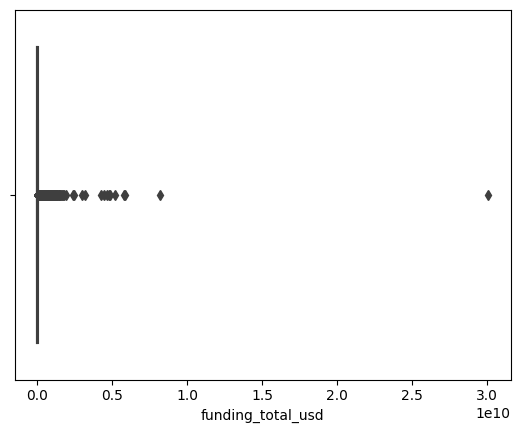

In [64]:
sns.boxplot(x=train_df['funding_total_usd']);

Стартапы бывают разные. Возможно, отфильтровывать аномалии тут не стоит. Но посмотрим на них:

In [65]:
anomaly = train_df.query('funding_total_usd > 20000000000')
anomaly

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
35029,Verizon Communications,3.007950e+10,1,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,...,0,0,0,0,0,0,0,0,0,0


Verison - известная компания. Странно, что первый фандинг заявлено, что был 2010-01-26. Удалим, чтобы не вносила такой всплеск.

In [66]:
train_df = train_df.drop(anomaly.index, axis=0).reset_index(drop=True)

In [67]:
def draw_pie_by_column(column):
    column.value_counts().plot(title="", kind='pie', autopct=lambda x: f"{x:.0f}%");

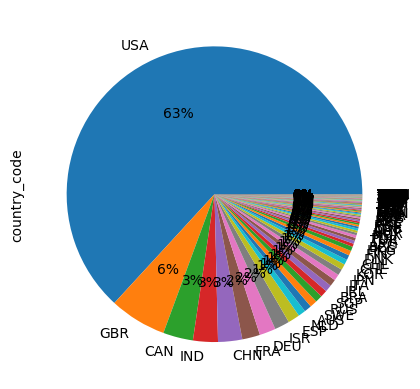

In [68]:
draw_pie_by_column(train_df['country_code'])

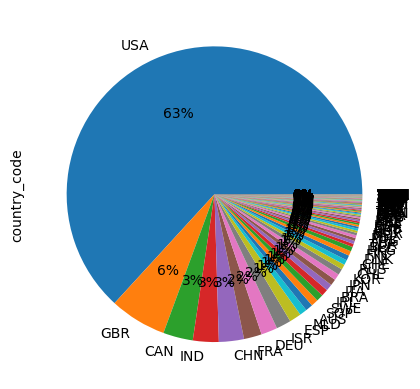

In [70]:
draw_pie_by_column(train_df.query('status==1')['country_code'])

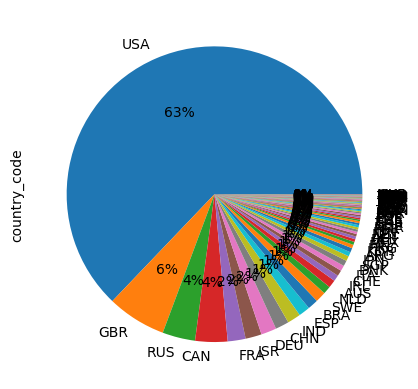

In [71]:
draw_pie_by_column(train_df.query('status==0')['country_code'])

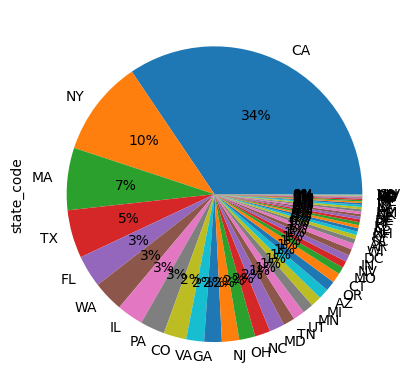

In [72]:
draw_pie_by_column(train_df.query('country_code=="USA"')['state_code'])

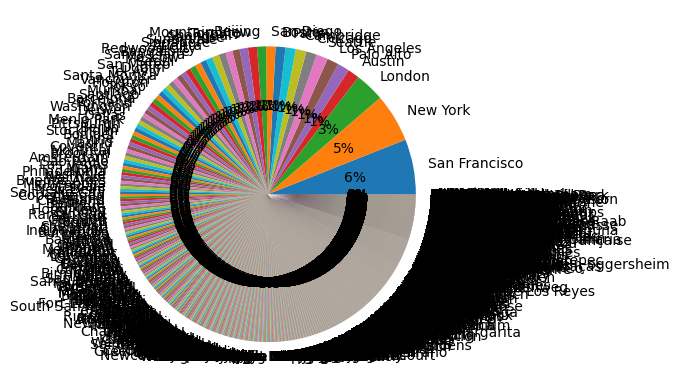

In [73]:
draw_pie_by_column(train_df['city'])

In [74]:
train_df

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,cat_education,cat_entertainments,cat_animals,cat_sport,cat_materials,cat_transport,cat_other,cat_real estate,cat_kids,cat_geography
0,Lunchgate,828626.0,1,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,...,0,0,0,0,0,0,0,0,0,0
1,EarLens,42935019.0,1,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,...,0,0,0,0,0,0,0,0,0,0
2,Reviva Pharmaceuticals,35456381.0,1,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,...,0,0,0,0,0,0,0,0,0,0
3,WireTough Cylinders,2133000.0,1,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,...,0,0,0,0,0,0,0,0,0,0
4,Connected Sports Ventures,4300000.0,1,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46966,Videostream,2133000.0,1,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,...,0,1,0,0,0,0,0,0,0,0
46967,Hello Curry,500000.0,1,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,...,0,0,0,0,0,0,0,0,0,0
46968,Taskforce,50000.0,1,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,...,0,0,0,0,0,0,0,0,0,0
46969,NetScaler,13000000.0,1,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,...,0,0,0,0,0,0,0,0,0,0


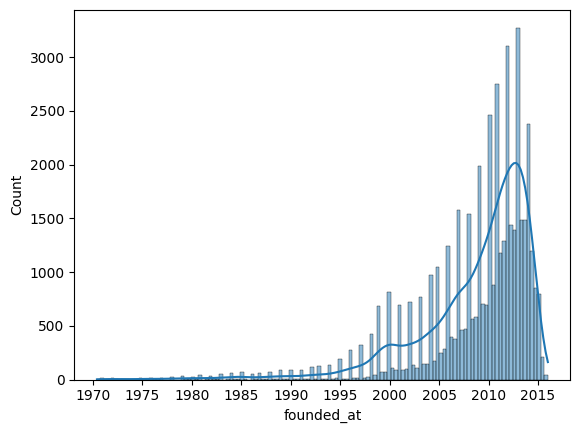

In [75]:
sns.histplot(data = train_df, x = 'founded_at', kde = True);

In [76]:
train_df['founded_at'].describe()

C:\Users\Papa\AppData\Local\Temp\ipykernel_27972\1640575367.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_df['founded_at'].describe()


count                   46971
unique                   5053
top       2012-01-01 00:00:00
freq                     2017
first     1970-06-04 00:00:00
last      2016-01-01 00:00:00
Name: founded_at, dtype: object

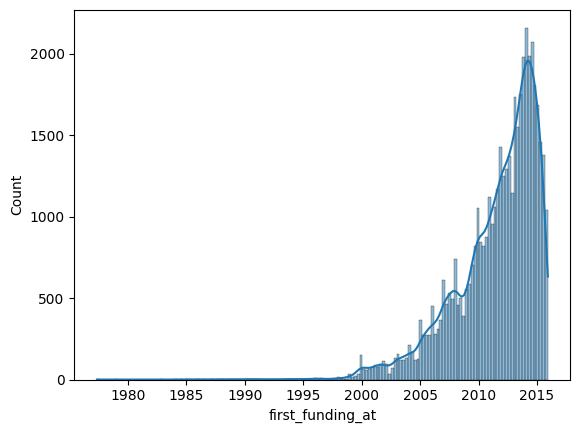

In [77]:
sns.histplot(data = train_df, x = 'first_funding_at', kde = True);

In [78]:
train_df['first_funding_at'].describe()

C:\Users\Papa\AppData\Local\Temp\ipykernel_27972\845624356.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_df['first_funding_at'].describe()


count                   46971
unique                   4495
top       2013-01-01 00:00:00
freq                      385
first     1977-05-15 00:00:00
last      2015-12-05 00:00:00
Name: first_funding_at, dtype: object

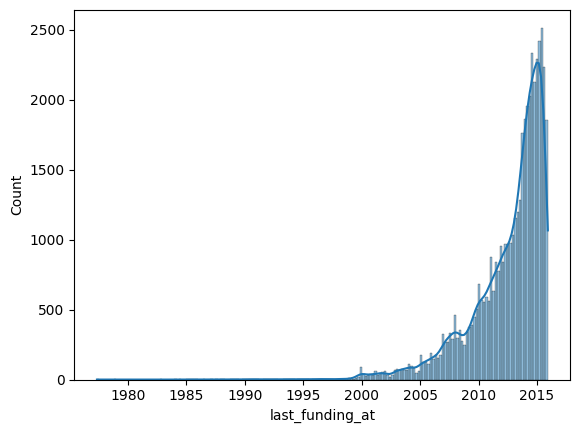

In [79]:
sns.histplot(data = train_df, x = 'last_funding_at', kde = True);

In [80]:
train_df['last_funding_at'].describe()

C:\Users\Papa\AppData\Local\Temp\ipykernel_27972\2295931701.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_df['last_funding_at'].describe()


count                   46971
unique                   4167
top       2014-01-01 00:00:00
freq                      277
first     1977-05-15 00:00:00
last      2015-12-07 00:00:00
Name: last_funding_at, dtype: object

Изучим какие крупные категории встречаются чаще всего:

In [81]:
df_cat = train_df.drop(['name', 'funding_total_usd', 'country_code', 'state_code', 
                        'region', 'city', 'funding_rounds', 'founded_at',
                          'first_funding_at', 'last_funding_at'], axis=1)
df_cat.sum().sort_values(ascending=False)

status                43344
cat_it                21767
cat_health             7569
cat_technics           7208
cat_marketing          6877
cat_service            5904
cat_media              5760
cat_manufacturing      4123
cat_entertainments     3634
cat_finance            3468
cat_social             2868
cat_consulting         2723
cat_goods              2300
cat_education          1830
cat_ecology            1470
cat_transport          1322
cat_real estate        1054
cat_sport               895
cat_food                622
cat_materials           275
cat_kids                257
cat_other               196
cat_animals             103
cat_geography             4
dtype: int64

Изучим какие крупные категории встречаются чаще всего среди успешных стартапов:

In [82]:
df_cat.query('status==1').sum().sort_values(ascending=False)

status                43344
cat_it                19996
cat_health             7162
cat_technics           6642
cat_marketing          6339
cat_service            5413
cat_media              5194
cat_manufacturing      3874
cat_entertainments     3323
cat_finance            3237
cat_social             2614
cat_consulting         2529
cat_goods              2157
cat_education          1733
cat_ecology            1362
cat_transport          1240
cat_real estate        1008
cat_sport               831
cat_food                596
cat_materials           256
cat_kids                230
cat_other               187
cat_animals              95
cat_geography             4
dtype: int64

Изучим какие крупные категории встречаются чаще всего среди неуспешных стартапов:

In [83]:
df_cat.query('status==0').sum().sort_values(ascending=False)

cat_it                1771
cat_technics           566
cat_media              566
cat_marketing          538
cat_service            491
cat_health             407
cat_entertainments     311
cat_social             254
cat_manufacturing      249
cat_finance            231
cat_consulting         194
cat_goods              143
cat_ecology            108
cat_education           97
cat_transport           82
cat_sport               64
cat_real estate         46
cat_kids                27
cat_food                26
cat_materials           19
cat_other                9
cat_animals              8
status                   0
cat_geography            0
dtype: int64

💡[!] Выводы по итогам EDA
- страны:
    - Подавляющее большинство стартапов в датасете  - из США (63%)
    - на втором месте Великобритания (6%)
    - на третьем Канада (3%)
- TOP3 штатов США по числу стартапов:
    - CA (34%)
    - NY (10%)
    - MA (7%)
- TOP3 городов мира по числу стартапов:
    - San Francisco (6%)
    - New York (5%)
    - London (3%)

## разработка новых синтетических признаков

- В тестовой выборке столбец lifetime был заменён недостающим столбцом founded_at (в разделе предобработки данных).
- Также выше были созданы столбцы для категорий (в разделе предобработки данных).

Поля с датами представим в виде чисел:

In [84]:
def encode_dates (df):
    for c in df:
        if is_datetime(df[c].dtype):
            df[f"{c}_y"] = df[c].dt.year
            df[f"{c}_m"] = df[c].dt.month
            df[f"{c}_d"] = df[c].dt.day
            df = df.drop(c, axis=1)
    return df

In [85]:
train_df = encode_dates(train_df)
test_X_df = encode_dates(test_X_df)

🏭 [data transformation] this change ⤴️ should be done before training/testing/inference

Также ни на что не влияет name - удалим его из train и test:

In [86]:
train_df = train_df.drop('name', axis=1)
test_X_df = test_X_df.drop('name', axis=1)

🏭 [data transformation] this change ⤴️ should be done before training/testing/inference

## проверка на мультиколлинеарность

c:\Users\Papa\.conda\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable city is large: 4477. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
c:\Users\Papa\.conda\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1036. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(


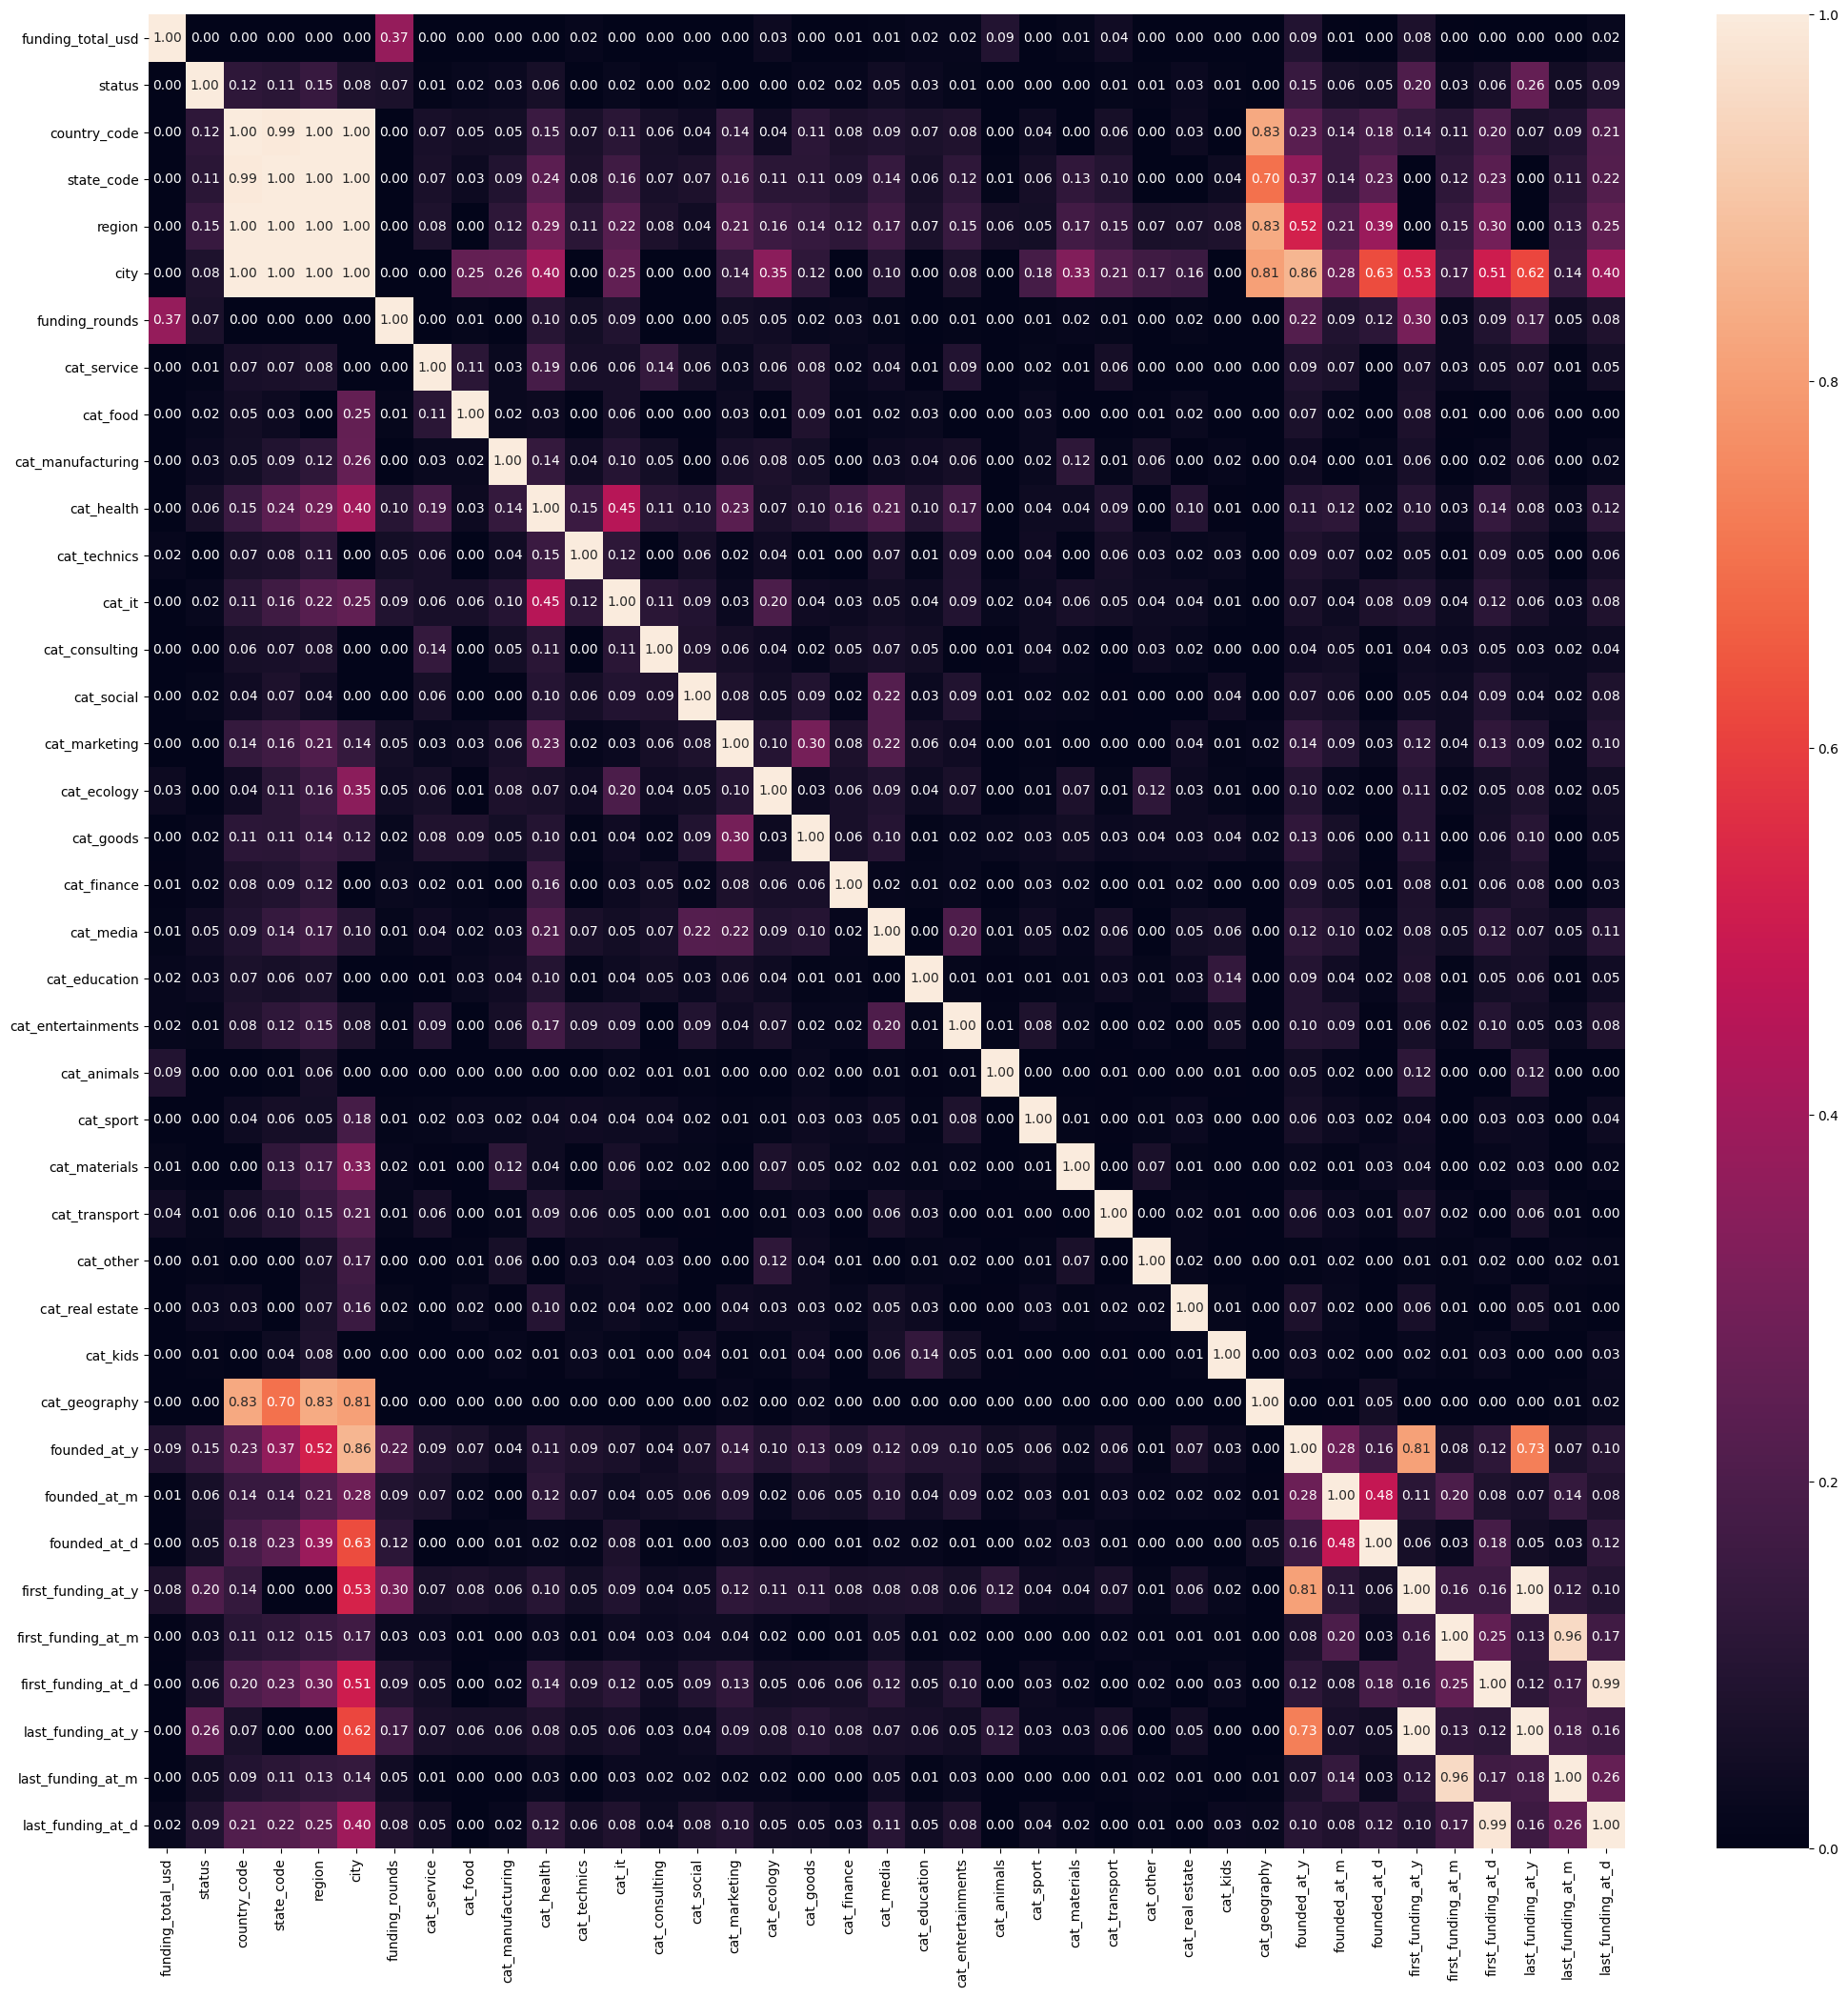

In [87]:
_, ax = plt.subplots(figsize=(25,25))
sns.heatmap(train_df.phik_matrix(interval_cols=['funding_total_usd'], \
            bins={'funding_total_usd':10}), annot=True, fmt='.2f', ax=ax);

Выявлена мультиколлинеарность >=0.95:
- country_code, state_code, city, region
- first_funding_at и last_funding_at
- 

👷✅ решено не брать в фичи state_code, first_funding_at, оставив только country_code и last_funding_at.

In [88]:
train_df = train_df.drop(['state_code', 'city', 'region', 'first_funding_at_y', 
                          'first_funding_at_m', 'first_funding_at_d'], axis=1)
test_X_df = test_X_df.drop(['state_code', 'city', 'region', 'first_funding_at_y', 
                          'first_funding_at_m', 'first_funding_at_d'], axis=1)

🏭 [data transformation] this change ⤴️ should be done before training/testing/inference

перепроверим дубликаты:

In [89]:
display(train_df.duplicated().sum())

33

удалим их:

In [90]:
train_df = train_df.drop_duplicates().reset_index(drop=True)

In [91]:
train_df

,funding_total_usd,status,country_code,funding_rounds,cat_service,cat_food,cat_manufacturing,cat_health,cat_technics,cat_it,...,cat_other,cat_real estate,cat_kids,cat_geography,founded_at_y,founded_at_m,founded_at_d,last_funding_at_y,last_funding_at_m,last_funding_at_d
0,828626.0,1,CHE,2,1,1,0,0,0,0,...,0,0,0,0,2009,10,17,2014,12,1
1,42935019.0,1,USA,4,0,0,1,1,0,0,...,0,0,0,0,2005,1,1,2014,2,25
2,35456381.0,1,USA,3,0,0,0,1,0,0,...,0,0,0,0,2006,1,1,2014,7,2
3,2133000.0,1,USA,1,0,0,1,0,0,0,...,0,0,0,0,2010,5,12,2012,2,1
4,4300000.0,1,USA,1,0,0,0,0,1,0,...,0,0,0,0,2011,4,16,2012,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46933,2133000.0,1,CAN,1,0,0,0,0,0,0,...,0,0,0,0,2012,1,1,2014,3,1
46934,500000.0,1,IND,1,1,0,0,0,0,0,...,0,0,0,0,2013,8,25,2014,3,7
46935,50000.0,1,USA,3,0,0,0,0,0,1,...,0,0,0,0,2010,7,1,2011,1,1
46936,13000000.0,1,USA,6,1,0,0,0,0,0,...,0,0,0,0,1997,12,1,2004,3,1


## отбор финального набора обучающих признаков

Проведённые выше преобразования фичей:
- закодировен столбец category_list
- закодирована целевая фича status
- удалён столбец closed_at (во избежание утечки целевого признака и данных)
- в тренировочной выборке сконструирована фича founded_at и удалена фича lifetime
- все country_code переведены к верхнему регистру во избежание неявных дубликатов
- удалён признак name (как неинформативный и имеющий слишком много значений)
- даты закодированы в виде оддельных признаков: код, месяц, день
- ввиду мультиколлинеарности удалены признаки: 'state_code', 'city', 'region', 'first_funding_at'

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46938 entries, 0 to 46937
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   funding_total_usd   46938 non-null  float64
 1   status              46938 non-null  int64  
 2   country_code        46938 non-null  object 
 3   funding_rounds      46938 non-null  int64  
 4   cat_service         46938 non-null  int64  
 5   cat_food            46938 non-null  int64  
 6   cat_manufacturing   46938 non-null  int64  
 7   cat_health          46938 non-null  int64  
 8   cat_technics        46938 non-null  int64  
 9   cat_it              46938 non-null  int64  
 10  cat_consulting      46938 non-null  int64  
 11  cat_social          46938 non-null  int64  
 12  cat_marketing       46938 non-null  int64  
 13  cat_ecology         46938 non-null  int64  
 14  cat_goods           46938 non-null  int64  
 15  cat_finance         46938 non-null  int64  
 16  cat_

### анализ сбалансированности выборки

In [93]:
train_df['status'].value_counts(normalize=True)

1    0.922792
0    0.077208
Name: status, dtype: float64

In [94]:
train_df['status'].value_counts()

1    43314
0     3624
Name: status, dtype: int64

Выборка очень не сбалансирована!

- Если делать undersampling - то датасет получтися сильно меньше относительно исходного.
- Но и синтезировать в 12 раз класс-0 данных тоже не выглядит перспективно.
- Попробую использовать SMOTETomek (который комбинирует oversampling с помощью SMOTE и undersampling с помощью TOMEK) и pipeline.
    - UPD: 👷🚨[SOS] не получилось - при использовании make_pipeline из imblearn.pipeline получал ошибки, которые так и не удалось решить за приемлемое время. Попробую отдельно в пайлайн передать RandomUnderSampler и SMOTENC:
    - UPD: 👷🚨[SOS] тоже не получилось: `TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTENC(categorical_features=['country_code'], random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTENC'>) doesn't`
    - 👷✅ придётся балансировать датасет вручную, вне пайплайна. Предположу, что можем себе позволить увеличить класс-1 при помощи oversampling не более чем в 2 раза - уменьшим класс-1 до ~7000, и увеличим класс-0 также до ~7000:

In [95]:
y = train_df['status']
X = train_df.drop('status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=RANDOM_STATE)

In [96]:
sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
X_train, y_train = sampler.fit_resample(X_train, y_train) 
y_train.value_counts()

c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


1    6530
0    3265
Name: status, dtype: int64

In [97]:
sampler = SMOTENC(categorical_features=['country_code'], 
                  random_state=RANDOM_STATE, k_neighbors=50)
X_train, y_train = sampler.fit_resample(X_train, y_train)
y_train.value_counts()

c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


0    6530
1    6530
Name: status, dtype: int64

## выбор и обучение моделей

In [98]:
ohe_pipe_columns = [
    'country_code'
]

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('num', StandardScaler())
    ]
)

num_columns = list(X_train.columns)
num_columns.remove('country_code')

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_pipe_columns),
        ('num', num_pipe, num_columns),
    ], 
    remainder='passthrough'
) 

In [99]:
%%time

#pipe_final = make_pipeline_with_sampler([
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
#    ('smote_tomek', SMOTETomek(random_state=RANDOM_STATE)),
#    ('downsampler', RandomUnderSampler(sampling_strategy=0.25, random_state=RANDOM_STATE)),
#    ('upsampler', SMOTENC(categorical_features=ohe_pipe_columns, random_state=RANDOM_STATE, k_neighbors=5)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
]
)

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': [4,7],
        'models__max_features': [10, 50],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    }
    ,
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [10, 20],
        'models__min_samples_split': [5, 10],
        'models__min_samples_leaf': [2, 4],
        'models__bootstrap': [True, False],
        'preprocessor__num': [MinMaxScaler()]   
    }
    ,
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            class_weight='balanced'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    }
    ,
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            kernel='linear', probability=True, class_weight='balanced'
        )],
        'models__kernel': ['poly', 'rbf'],
        'models__degree': [2, 5, 10],
        'models__C': range(2, 3),
    }
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=3,
    scoring='f1',
    verbose = 10,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 34 candidates, totalling 102 fits
CPU times: total: 2min 7s
Wall time: 9min 36s


In [100]:
grid_search.best_params_

{'models': SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42),
 'models__C': 2,
 'models__degree': 2,
 'models__kernel': 'rbf'}

## итоговая оценка качества предсказания лучшей модели

### Оценка на кроссвалидации

In [101]:
display('Лучшая модель и её параметры: ', best_model)
display ('f1 лучшей модели на кроссвалидации: ', grid_search.best_score_)

'Лучшая модель и её параметры: '

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer(strategy='median'))...
                                                   'cat_finance', 'cat_media',
                                                   'cat_education',
                                                   'cat_entertainments',
                                                   'cat_animals', 'cat_sport',
                                                   'cat_materials',
                                                   'cat_transport', 'cat_other',
                                                   'cat_real estate',
                                                   'cat_kids', 'cat_geography',
                                                   'founded_at_y',
                                                   'founded_at_m',
                                                   'founded_at_d',
                                                   'last_funding_at_y',
                                                   'last_funding_at_m', ...])])),
                ('models',
                 SVC(C=2, class_weight='balanced', degree=2, probability=True,
                     random_state=42))])

'f1 лучшей модели на кроссвалидации: '

0.7606043894264053

### оценка на тестовой выборке

In [102]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.18      0.52      0.27       359
           1       0.95      0.81      0.87      4335

    accuracy                           0.79      4694
   macro avg       0.57      0.66      0.57      4694
weighted avg       0.89      0.79      0.83      4694



c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


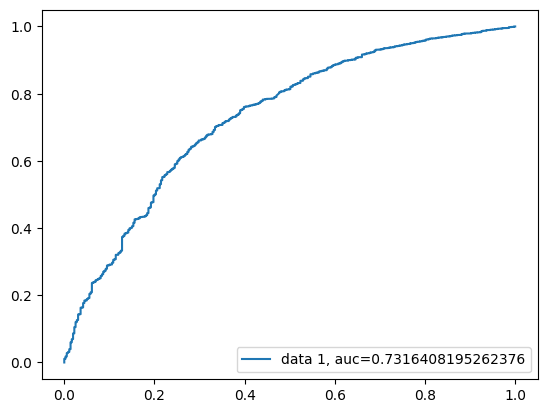

In [103]:
y_pred_proba = best_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Подготовка предиктов на тетствой выборке

In [104]:
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
test_X_df_preprocessed = preprocessor.transform(test_X_df)


c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [105]:
test_X_df

,funding_total_usd,country_code,funding_rounds,cat_ecology,cat_service,cat_finance,cat_it,cat_entertainments,cat_media,cat_health,...,cat_materials,cat_animals,cat_other,cat_geography,last_funding_at_y,last_funding_at_m,last_funding_at_d,founded_at_y,founded_at_m,founded_at_d
0,2819200.0,NIC,1,1,0,0,0,0,0,0,...,0,0,0,0,2009,7,1,2008,6,1
1,NaN,USA,1,0,1,0,0,0,0,0,...,0,0,0,0,2010,7,28,2010,7,25
2,428257.0,LUX,2,0,0,1,0,0,0,0,...,0,0,0,0,2014,9,18,2014,6,16
3,34700000.0,USA,4,0,0,0,1,1,0,0,...,0,0,0,0,2010,4,20,2005,1,1
4,4530000.0,CAN,1,0,0,0,1,0,0,0,...,0,0,0,0,2007,5,8,2001,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,28000.0,USA,1,0,1,0,0,0,0,0,...,0,0,0,0,2012,7,1,2011,10,18
13121,NaN,USA,1,0,0,0,1,0,0,0,...,0,0,0,0,2013,10,1,2012,1,1
13122,5600000.0,USA,3,0,1,0,0,0,1,0,...,0,0,0,0,2011,6,28,2010,1,1
13123,150000.0,USA,2,0,0,0,1,0,0,0,...,0,0,0,0,2014,11,4,2014,3,17


In [106]:
y_report = best_model.predict(test_X_df)

c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [107]:
X_df = def_load_csv ('kaggle_startups_test_28062024.csv', no_print=True)

In [114]:
report = pd.DataFrame({'name': X_df['name'], 'status': y_report})
report['status'] = report['status'].apply (lambda x: 'operating' if x==1 else 'closed')
report

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,closed
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,closed
...,...,...
13120,Jymob,closed
13121,GlobaTrek,closed
13122,Inkd.com,operating
13123,AdWill,operating


In [115]:
report.to_csv('kaggle_startups_ES_submit_090325.csv', index=False)

## анализ важности признаков

c:\Users\Papa\.conda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

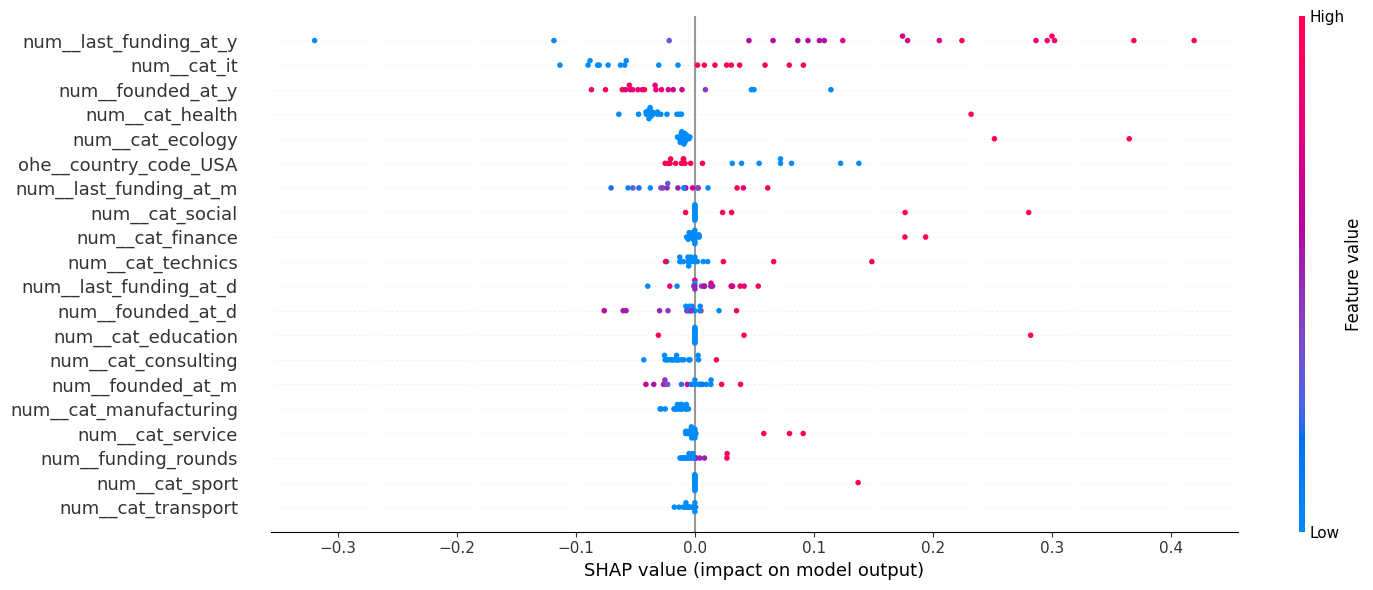

In [110]:
samples = 20
 
# Извлечение лучшей модели из результатов RandomizedSearchCV
best_model = grid_search.best_estimator_.named_steps['models']

# Предобработка данных через пайплайн без конечной модели
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

all_feature_names = preprocessor.get_feature_names_out()

# Создаем DataFrame с соответствующими именами колонок
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, 
                                       columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, 
                                      columns=all_feature_names)

# Семпл данных для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, 
                                        samples, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, 
                                       samples, random_state=RANDOM_STATE)

# Теперь, когда у нас есть DataFrame с именами признаков, мы можем использовать KernelExplainer
###explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_smpl)
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

# Создаем объект Explanation для первого КЛАССА.
shap_values_explanation = shap.Explanation(
    values=shap_values[:,:,1], 
    base_values=explainer.expected_value,
    data=X_test_preprocessed_smpl,
    feature_names=all_feature_names
)

shap.summary_plot(shap_values_explanation, plot_size=[15,6])
plt.show()

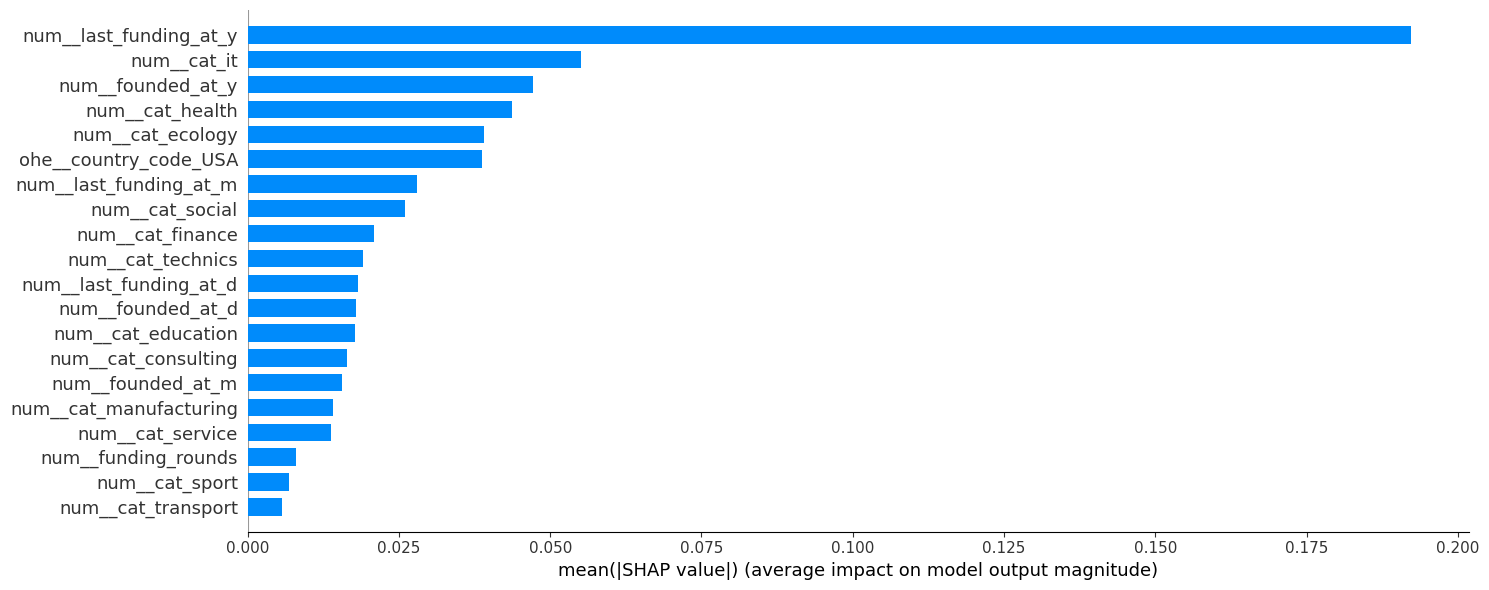

In [111]:
#shap.plots.bar(shap_values_explanation)
shap.summary_plot(shap_values_explanation, plot_size=[15,6], plot_type='bar')
plt.show()

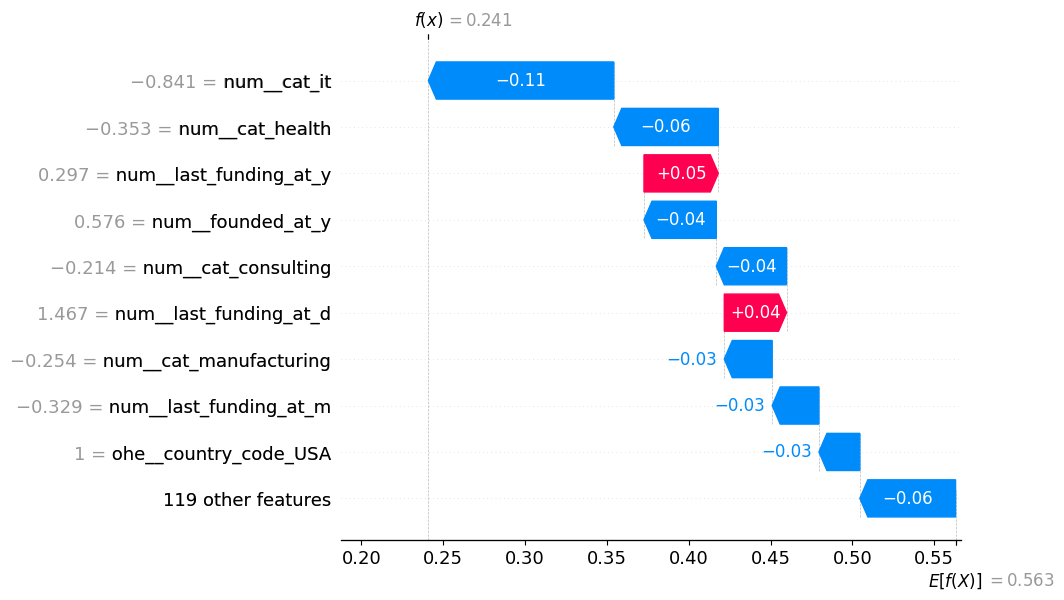

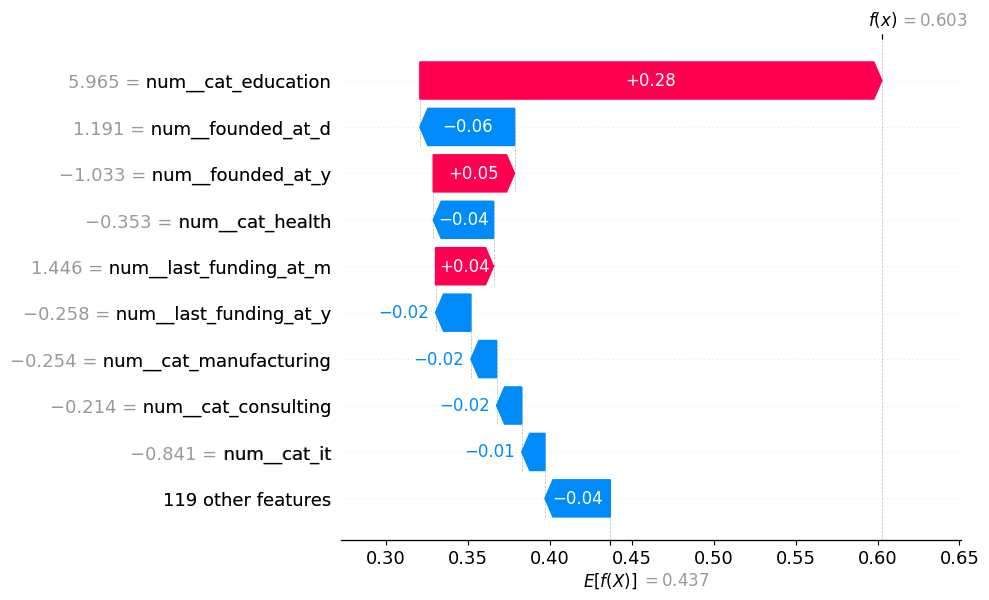

In [112]:
shap.plots.waterfall(shap_values_explanation[0]);
shap.plots.waterfall(shap_values_explanation[1]);
#shap.plots.waterfall(shap_values_explanation[2]);
plt.show()

### Выводы по важности признаков

TOP3 наиболее характерных признаков для успешного стартапа:
- country_code = USA
- год основания
- кастегория бизнеса = IT

# Отчет по исследованию

## Целью проекта являлось

- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. Мера качества: F1-Score.
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).





## разработанная модель

Лучшие результаты показала модель SVC:
- на тестовой выборке:
    - f1 = 0.87
    - precision = 0.95
    - recall = 0.81
    - roc-auc = 
- на кроссвалидации: 
    - f1 = 0.76
- параметры модели
    - (kernel=rbf, C=2, class_weight='balanced', degree=2, probability=True, random_state=42)

Для разработки модели были проведены следующие шаги:
- загружены и изучены предоставленные датасеты
- исправлены типы признаков
- удалены дубликаты
- удалены избыточные и добавлены недостающие признаки
- обработаны пропуски в обучающей выборке
- унифицированы значения признаков, укрупнены/заменены некоторые из них
- устранена утечка данных/модели
- изучены статистики данных
- удалены явные аномалии
- устранена мультиколлинеарность
- устранена несбалансированность обучающей выборки (down+up sampling)
- при помощи GridSearchCV произведён автоматический перебор обучения моделей (и их гиперпараметров):
    - DecisionTreeClassifier
    - RandomForestClassifier
    - LogisticRegression
    - SVC
- обучение проводилось при помощи кроссвалидации на 3 фолда
- для оценки качества использовалась небольшая выборка с разметкой, предварительно отложенная из обучающего датасета, она не входила в обучение/кроссвалидацию

## рекомендации будущим создателям стартапов 

Рекомендация: учитывать как благоприятные - признаки, выбранные моделью, а также наиболее топовые из результатов разведочного анализа.

Наиболее характерные признаков для действующих стартапа (исходя из модели):
- год последнего инвестирования (чем менее давно, тем лучше)
- укрупнённая категория бизнеса = IT
- год основания (чем старше, тем лучше)
- укрупнённая категория бизнеса = Health
- укрупнённая категория бизнеса = Ecology
- страна = США

Сопутствующие наблюдения по итогам разведочного анализа данных:
- TOP5-категорий действующих стартапов (с точностю до укрупнённых по словарю категорий):
    - IT (с заметным отрывом)
    - Health
    - Technics
    - Marketing
    - Service
- TOP5-категорий закрытых стартапов (с точностю до укрупнённых по словарю категорий):
    - Technics
    - Media
    - Marketing
    - Service
    - Health
- страны:
    - Подавляющее большинство стартапов в датасете  - из США (63%)
    - на втором месте Великобритания (6%)
    - на третьем Канада (3%)
- TOP3 стран действующих стартапов:
    - USA
    - GBR
    - CAN
- TOP3 стран закрытых стартапов:
    - USA
    - GBR
    - RUS
- TOP3 штатов США по числу стартапов:
    - CA (34%)
    - NY (10%)
    - MA (7%)
- TOP3 городов мира по числу стартапов:
    - San Francisco (6%)
    - New York (5%)
    - London (3%)
- Согласно статистике по годам, количество стартапов с 2000г неуклонно растёт.

# Appendix - comments legend

These icons and [tags] were used to simplify visualization and searching for conclusions, open questions and subtasks, not to forget to finish/check something important. It's convenient to copy a cell from here and paste it into the right place, adding details.

👷🚩[todo] = this task is to be done

👷✅ = the task has been done

👷🚨[SOS] = need help

👷🔔[reminder] = some work to do or check later

⚠️[!] = important constraints or facts

💡 [!]= something interesting

🏭 [data transformation] this change ⤴️ should be done before training/testing/inference

👷🚧🚧🚧🚧🚧 [in progress] = in progress right now

🚧⬇️🚧⬇️🚧⬇️🚧⬇️🚧⬇️🚧⬇️🚧⬇️🚧⬇️🚧⬇️🚧⬇️🚧

➡️ some code to be reworked ⬅️

🚧⬆️🚧⬆️🚧⬆️🚧⬆️🚧⬆️🚧⬆️🚧⬆️🚧⬆️🚧⬆️🚧⬆️🚧